# Melanoma Classification

> Martha Rebeca Canales Fiscal.
>
> 24/Nov/2020.
>
> In this notebook a process of image processing, lesion segmentation, feature extraction and data transformation is performed to conduct a classification of skin lesions as benign and malignant from the ISIC-Melanoma dataset. Five classifiers are used: SVM, KNN, Gaussian Naive Bayes, LDA and Decision Tree.

In [1]:
import pydicom
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from skimage.filters import threshold_otsu
import numpy as np
from skimage.color import rgb2gray
from skimage import exposure
from skimage import morphology
from skimage import segmentation
from skimage.filters.rank import median
from skimage.morphology import disk
from pandas import DataFrame

#Variable declaration
train_path = './Documents/Doctorado/SIIM ISIC Melanoma Classification/Imagenes/Training/train'
test_path = './Documents/Doctorado/SIIM ISIC Melanoma Classification/Imagenes/Testing/test'
train_path_csv = './Documents/Doctorado/SIIM ISIC Melanoma Classification/Imagenes/Training/.csv'
test_path_csv = './Documents/Doctorado/SIIM ISIC Melanoma Classification/Imagenes/Testing/.csv'

train_df = pd.read_csv(train_path_csv)
test_df = pd.read_csv(test_path_csv)

#Function to read dicom files
def open_dicom(path):
    files_hair = []
    files = os.listdir(path)
    files_hair.append(files[225])
    files_hair.append(files[736])
    files_hair.append(files[1142])
    files_hair.append(files[1173])
    files_hair.append(files[1177])
    images = []
    for file in files_hair:
        if file != '.csv':
            file_path = os.path.join(path, file)
            dicom_image = pydicom.dcmread(file_path)
            dicom_image = dicom_image.pixel_array
            #plt.imshow(dicom_image, cmap=plt.cm.bone)
            images.append(dicom_image)
    return images

#Function to EDA
def eda(train_df, test_df):
    #Shape of datasets
    print("Train dataset shape: ", train_df.shape)
    print("Test dataset shape: ", test_df.shape)
    print("\n")
    
    #Null values and datatypes
    print(train_df.info())
    print("\n")
    print(test_df.info())
    print("\n")
    
    #No. of patients id and unique ids
    print(f"The total patient ids in training set are {train_df['patient_id'].count()}, from those the unique ids are {train_df['patient_id'].value_counts().shape[0]} ")
    print(f"The total patient ids in testing set are {test_df['patient_id'].count()}, from those the unique ids are {test_df['patient_id'].value_counts().shape[0]} ")
    print("\n")
    
    #Balance of classes
    df_target = train_df['target'].value_counts()
    print("Number of clases:")
    print(df_target)
    df_target.plot(kind='bar', title='Number of Classes')
    print("\n")
    
    #Sex by classes
    df_sex_target = train_df.groupby(['target','sex'])['benign_malignant'].count()
    print("Number of females and males by class:")
    print(df_sex_target)
    df_sex_target.unstack().plot(kind='bar', title='Classes by sex')
    print("\n")
    
    #Localization of melanoma by sex
    df_sex_loc = train_df.groupby(['anatom_site_general_challenge','sex'])['benign_malignant'].count()
    print("Localication of the tumor by sex:")
    print(df_sex_loc)
    df_sex_loc.unstack().plot(kind='bar', title='Localization of melanoma by sex')
    print("\n")
    
    #Localization of melanoma by target
    df_target_loc = train_df.groupby(['anatom_site_general_challenge','target'])['benign_malignant'].count()
    print("Localization of the tumor by class:")
    print(df_target_loc)
    df_target_loc.unstack().plot(kind='bar', title='Localization of melanoma by target')
    print("\n")
    
    #Age
    df_age = train_df.groupby(['age_approx'])['benign_malignant'].count()
    print("Age:")
    print(df_age)
    df_age.plot(kind='bar', title='Age')
    print("\n")
    
    #Diagnosis
    df_diagnosis = train_df.groupby(['diagnosis'])['benign_malignant'].count()
    print("Diagnosis:")
    print(df_diagnosis)
    df_diagnosis.plot(kind='bar', title='Diagnosis')
    print("\n")

#Function to plot images
def plot_images(images):
    fig = plt.figure()
    a = fig.add_subplot(3, 2, 1)
    imgplot = plt.imshow(images[0],cmap=plt.cm.bone)
    a = fig.add_subplot(3, 2, 2)
    imgplot = plt.imshow(images[1],cmap=plt.cm.bone)
    a = fig.add_subplot(3, 2, 3)
    imgplot = plt.imshow(images[2],cmap=plt.cm.bone)
    a = fig.add_subplot(3, 2, 4)
    imgplot = plt.imshow(images[3],cmap=plt.cm.bone)
    a = fig.add_subplot(3, 2, 5)
    imgplot = plt.imshow(images[4],cmap=plt.cm.bone)

eda(train_df, test_df)
temp_images = open_dicom(train_path)
hair_images = open_dicom(train_path)

Using TensorFlow backend.
C:\Users\marth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\marth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\marth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\marth\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
import random

#Build filenames for ImageDataGenerator
def load_complete_dataset():
    def dcm_tag(image_name):
        return image_name+'.DCM'

    train_df['image_name']=train_df['image_name'].apply(dcm_tag)
    test_df['image_name']=test_df['image_name'].apply(dcm_tag)
    train_df['target'] = train_df['target'].astype('str')
    train_df.head()

    #Load, rescale and resize images
    datagen = ImageDataGenerator()
    train = datagen.flow_from_dataframe(dataframe=train_df, directory=train_path, x_col='image_name', y_col='target', target_size=(1024, 1024), batch_size=32, interpolation="nearest", class_mode="binary")
    test = datagen.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col='image_name', target_size=(1024, 1024), batch_size=32, interpolation="nearest", class_mode=None)
    
def load_partial_dataset(path, train_df):
    malignant = train_df[train_df['target']==1]
    no_malignant = train_df[train_df['target']==0]
    malignant = malignant[402:602]
    no_malignant = no_malignant[603:1003]
    malig_names = malignant['image_name']
    no_malig_names = no_malignant['image_name']

    def dcm_tag(image_name):
        return image_name+'.dcm'

    malig_names = malig_names.apply(dcm_tag)
    no_malig_names = no_malig_names.apply(dcm_tag)
    malig_names.head()
    
    images1 = []
    images2 = []
    #n = 1
    for file in malig_names:
        if file != '.csv':
            file_path = os.path.join(path, file)
            dicom_image = pydicom.dcmread(file_path)
            dicom_image = dicom_image.pixel_array
            #plt.imshow(dicom_image, cmap=plt.cm.bone)
            images1.append(dicom_image)
            #print('Image ' + str(n) + ' loaded')
            #n += 1
            
    for file in no_malig_names:
        if file != '.csv':
            file_path = os.path.join(path, file)
            dicom_image = pydicom.dcmread(file_path)
            dicom_image = dicom_image.pixel_array
            #plt.imshow(dicom_image, cmap=plt.cm.bone)
            images2.append(dicom_image)
            #print('Image ' + str(n) + ' loaded')
            #n += 1
    return images1, images2, malignant, no_malignant

def load_partial_dataset_wo_malig(path, train_df):
    no_malignant = train_df[train_df['target']==0]
    no_malignant = no_malignant[4212:4612]
    no_malig_names = no_malignant['image_name']

    def dcm_tag(image_name):
        return image_name+'.dcm'

    no_malig_names = no_malig_names.apply(dcm_tag)
    
    images1 = []
            
    for file in no_malig_names:
        if file != '.csv':
            file_path = os.path.join(path, file)
            dicom_image = pydicom.dcmread(file_path)
            dicom_image = dicom_image.pixel_array
            #plt.imshow(dicom_image, cmap=plt.cm.bone)
            images1.append(dicom_image)
            #print('Image ' + str(n) + ' loaded')
            #n += 1
    return images1, no_malignant


def shuffle_data(img_malig, img_no_malig, malignant_df, no_malignant_df):
    img = np.concatenate((img_malig, img_no_malig))
    df = pd.concat([malignant_df, no_malignant_df])
    label = df['target']
    label = label.to_numpy()
    img_label = np.dstack((img, label))
    img_label = img_label[0]
    img_label = list(img_label)
    img_label = random.sample(img_label, len(img_label))
    
    img_shuffled = []
    label_shuffled = []
    
    for element in img_label:
        image_label = element
        img_shuff = image_label[0]
        label_shuff = image_label[1]
        img_shuffled.append(img_shuff)
        label_shuffled.append(label_shuff)
    return img_shuffled, label_shuffled

def shuffle_data_wo_malig(img_no_malig, no_malignant_df):
    img = img_no_malig
    df = no_malignant_df
    label = df['target']
    label = label.to_numpy()
    img_label = np.dstack((img, label))
    img_label = img_label[0]
    img_label = list(img_label)
    img_label = random.sample(img_label, len(img_label))
    
    img_shuffled = []
    label_shuffled = []
    
    for element in img_label:
        image_label = element
        img_shuff = image_label[0]
        label_shuff = image_label[1]
        img_shuffled.append(img_shuff)
        label_shuffled.append(label_shuff)
    return img_shuffled, label_shuffled

img_malig, img_no_malig, malignant_df, no_malignant_df = load_partial_dataset(train_path, train_df)
img_no_malig, no_malignant_df = load_partial_dataset_wo_malig(train_path, train_df)
image, label = shuffle_data(img_malig, img_no_malig, malignant_df, no_malignant_df)
image, label = shuffle_data_wo_malig(img_no_malig, no_malignant_df)


54351


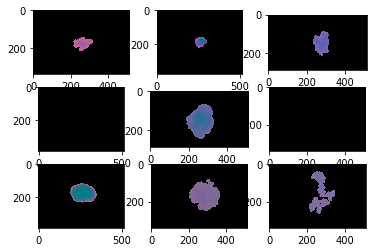

In [24]:
print(np.count_nonzero(lesion[67]))

#Plot images
fig = plt.figure()

a = fig.add_subplot(3, 3, 1)
imgplot = plt.imshow(lesion[63],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 2)
imgplot = plt.imshow(lesion[64],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 3)
imgplot = plt.imshow(lesion[65],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 4)
imgplot = plt.imshow(lesion[66],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 5)
imgplot = plt.imshow(lesion[67],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 6)
imgplot = plt.imshow(lesion[68],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 7)
imgplot = plt.imshow(lesion[69],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 8)
imgplot = plt.imshow(lesion[70],cmap=plt.cm.bone)
a = fig.add_subplot(3, 3, 9)
imgplot = plt.imshow(lesion[71],cmap=plt.cm.bone)

In [3]:
from skimage.morphology import disk
from skimage.color import rgb2gray
from skimage import img_as_float64
from skimage.color import rgb2hsv
from skimage.color import rgb2lab
from skimage.transform import resize

#Function to resize images
def resize_images(images):
    image_vector = []
    for img in images:
        width = 512 #columns
        heigth = int((512*img.shape[0])/img.shape[1])
        img_resized = resize(img, (heigth,width))
        image_vector.append(img_resized)
    return image_vector

#Function to segment lesion
def internal_roi(images):
        seg_set = []
        back_set = []
        mask = []
        close_masks = []
        close_filled_masks = []
        
        for imgs in images:
            grayscale = rgb2gray(imgs)
            
            thresh = threshold_otsu(grayscale) 
            binary = grayscale > thresh
            
            selem = disk(8)
            #close_mask = morphology.binary_closing(binary, selem=selem)
            close_mask = morphology.binary_dilation(binary, selem = selem)
            close_mask = np.invert(segmentation.clear_border(np.invert(close_mask)))
            close_mask = morphology.remove_small_holes(close_mask, area_threshold=300)
            close_mask = morphology.binary_erosion(close_mask, selem = selem)
            inv = np.invert(close_mask)
            
            #RGB Segmentation
            seg_r = inv*imgs[:,:,0]
            seg_g = inv*imgs[:,:,1]
            seg_b = inv*imgs[:,:,2]
            seg_rgb = np.dstack((seg_r, seg_g, seg_b))

            #RGB Background
            back_r = close_mask*imgs[:,:,0]
            back_g = close_mask*imgs[:,:,1]
            back_b = close_mask*imgs[:,:,2]
            back_rgb = np.dstack((back_r, back_g, back_b))
            
            seg_set.append(seg_rgb)
            back_set.append(back_rgb)
            mask.append(inv)
            close_masks.append(close_mask)
            
        return seg_set, back_set, mask
    
#Function to determine and segment contour of lesion
def external_roi(images, mask):
        masks = []
        external_rgb = []
        n = 0
        selem = disk(20)
        for msk in mask:
            dilate_mask = morphology.binary_dilation(msk, selem=selem)
            external_mask = np.bitwise_xor(dilate_mask, msk)
            imgs = images[n]
            
            #RGB
            seg_r = external_mask*imgs[:,:,0]
            seg_g = external_mask*imgs[:,:,1]
            seg_b = external_mask*imgs[:,:,2]
            seg_rgb = np.dstack((seg_r, seg_g, seg_b))
            
            n+=1
            
            masks.append(external_mask)
            external_rgb.append(seg_rgb)
        return external_rgb, masks

#Function to convert rgb to hsv
def rgb_to_hsv(lesion, background, border):
    lesions = []
    backs = []
    borders = []
    for i in range(len(lesion)):
        l = rgb2hsv(lesion[i])
        back = rgb2hsv(background[i])
        b = rgb2hsv(border[i])
        lesions.append(l)
        backs.append(back)
        borders.append(b)
    return lesions, backs, borders

#Function to convert rgb to cie-lab
def rgb_to_lab(lesion, background, border):
    lesions = []
    backs = []
    borders = []
    for i in range(len(lesion)):
        l = rgb2lab(lesion[i])
        back = rgb2lab(background[i])
        b = rgb2lab(border[i])
        lesions.append(l)
        backs.append(back)
        borders.append(b)
    return lesions, backs, borders
    
#Function to split channels
def split_channels(images):
    images_channel1 = []
    images_channel2 = []
    images_channel3 = []
    for img in images:
        img_channel1 = img[:,:,0]
        img_channel2 = img[:,:,1]
        img_channel3 = img[:,:,2]

        images_channel1.append(img_channel1)
        images_channel2.append(img_channel2)
        images_channel3.append(img_channel3)
    return images_channel1, images_channel2, images_channel3

def remove(lesion, background, mask, border, mask_border, label):
    complete_lesion = []
    complete_back = []
    complete_mask = []
    complete_border = []
    complete_mask_border = []
    complete_label = []
    count = 0
    for img in lesion:
        if np.count_nonzero(img) != 0:
            complete_lesion.append(img)
            complete_back.append(background[count])
            complete_mask.append(mask[count])
            complete_border.append(border[count])
            complete_mask_border.append(mask_border[count])
            complete_label.append(label[count])
        count += 1
    return complete_lesion, complete_back, complete_mask, complete_border, complete_mask_border, complete_label


image = resize_images(image)

lesion, background, mask = internal_roi(image)
border, mask_border = external_roi(image, mask)

lesion, background, mask, border, mask_border, label = remove(lesion,
                                                              background,
                                                              mask, border,
                                                              mask_border,
                                                              label)

lesion_hsv, back_hsv, border_hsv = rgb_to_hsv(lesion, background, border)
lesion_lab, back_lab, border_lab = rgb_to_lab(lesion, background, border)

#Split of channels
lesion_red, lesion_green, lesion_blue = split_channels(lesion)
back_red, back_green, back_blue = split_channels(background)
contour_red, contour_green, contour_blue = split_channels(border)

lesion_hue, lesion_sat, lesion_val = split_channels(lesion_hsv)
back_hue, back_sat, back_val = split_channels(back_hsv)
contour_hue, contour_sat, contour_val = split_channels(border_hsv)

lesion_lightness, lesion_colorA, lesion_colorB = split_channels(lesion_lab)
back_lightness, back_colorA, back_colorB = split_channels(back_lab)
contour_lightness, contour_colorA, contour_colorB = split_channels(border_lab)

#Plot images
#fig = plt.figure()
#plt.imshow(lesion_blue[0],cmap=plt.cm.bone)
#a = fig.add_subplot(2, 2, 1)
#imgplot = plt.imshow(lesion_lightness[0],cmap=plt.cm.bone)
#a = fig.add_subplot(2, 2, 2)
#imgplot = plt.imshow(lesion_colorA[0],cmap=plt.cm.bone)
#a = fig.add_subplot(2, 2, 3)
#imgplot = plt.imshow(lesion_colorB[0],cmap=plt.cm.bone)
#a = fig.add_subplot(2, 2, 4)
#imgplot = plt.imshow(back_lab[0])

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from skimage.feature import hog
from numpy.linalg import norm
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import moments
import math
from skimage import img_as_ubyte
import scipy
from skimage import transform
from skimage.color import rgb2luv

def extract_color_measures(images):
    mean_feature = []
    std_feature = []
    skew_feature = []
    kurtosis_feature = []
    for img in images:
        locs = np.where(img != 0)
        pixels = img[locs]
        mean_color = np.mean(pixels)
        std_color = np.std(pixels)
        skew_color = scipy.stats.skew(pixels)
        kur_color = scipy.stats.kurtosis(pixels)
        mean_feature.append(mean_color)
        std_feature.append(std_color)
        skew_feature.append(skew_color)
        kurtosis_feature.append(kur_color)
    return mean_feature, std_feature, skew_feature, kurtosis_feature

#Function to determine distance between geometric centroid and brightness centroid
def extract_distance_centroid(images, mask):
    n = 0
    distances = []
    
    for img in images:
        #Calculate brightness centroid
        moment_br = moments(img, order=3)
        br_centroid = (moment_br[1, 0] / moment_br[0, 0], moment_br[0, 1] / moment_br[0, 0])
        
        #Calculate geometric centroid
        moment_geo = moments(mask[n], order=3)
        geo_centroid = (moment_geo[1, 0] / moment_geo[0, 0], moment_geo[0, 1] / moment_geo[0, 0])
        
        n+=1
        
        #Calculate distance
        x = abs(geo_centroid[0] - br_centroid[0])
        y = abs(geo_centroid[1] - br_centroid[1])
        dist = math.sqrt(pow(x, 2) + pow(y, 2))
        distances.append(dist)
    return distances

#Function to extract color diversity features
def color_diversity(images):
    num_bins = []
    for img in images:
        hist = np.histogram(img, bins=16) #16 rows and 1 column
        n = 0
        for bin in hist[0]:
            if bin != 0:
                n +=1
        num_bins.append(n)
    return num_bins

#Function to extract L-norms features
def luv_l_norm_hist(lesion, border):
    l1_norm = []
    l2_norm = []
    for i in range(len(lesion)):
        luv_lesion = rgb2luv(lesion[i])
        luv_border = rgb2luv(border[i])

        hist_lesion = np.histogram(luv_lesion, bins=8)
        hist_border = np.histogram(luv_border, bins=8)

        hist = hist_lesion[0] - hist_border[0]

        l1 = norm(hist, 1)
        l2 = norm(hist)

        l1_norm.append(l1)
        l2_norm.append(l2)
    return l1_norm, l2_norm

#Function to extract GLCM features
def extract_glcm(images):
    contrast_res1 = []
    dissimilarity_res1 = []
    homogeneity_res1 = []
    ASM_res1 = []
    energy_res1 = []
    correlation_res1 = []
    
    contrast_res2 = []
    dissimilarity_res2 = []
    homogeneity_res2 = []
    ASM_res2 = []
    energy_res2 = []
    correlation_res2 = []
    
    contrast_res3 = []
    dissimilarity_res3 = []
    homogeneity_res3 = []
    ASM_res3 = []
    energy_res3 = []
    correlation_res3 = []
    
    for img in images:
        for i in range(3):
            if type(img[0,0])!= np.uint8:
                img = img_as_ubyte(img)
            
            glcm = greycomatrix(img,
                                distances=[1],
                                angles=[0, 45*(180/math.pi), 90*(180/math.pi), 135*(180/math.pi)],
                                levels=None,
                                symmetric=False,
                                normed=False
                               )
            glcm[0,:,:,:] = 0
            glcm[:,0,:,:] = 0
            
            contrast = greycoprops(glcm, 'contrast')
            dissimilarity = greycoprops(glcm, 'dissimilarity')
            homogeneity = greycoprops(glcm, 'homogeneity')
            ASM = greycoprops(glcm, 'ASM')
            energy = greycoprops(glcm, 'energy')
            correlation = greycoprops(glcm, 'correlation')
            
            img = transform.pyramid_reduce(img, downscale=2)
            img = img_as_ubyte(img)
            
            if i == 0:
                contrast_res1.append(contrast[0,0])
                dissimilarity_res1.append(dissimilarity[0,0])
                homogeneity_res1.append(homogeneity[0,0])
                ASM_res1.append(ASM[0,0])
                energy_res1.append(energy[0,0])
                correlation_res1.append(correlation[0,0])
            elif i == 1:
                contrast_res2.append(contrast[0,0])
                dissimilarity_res2.append(dissimilarity[0,0])
                homogeneity_res2.append(homogeneity[0,0])
                ASM_res2.append(ASM[0,0])
                energy_res2.append(energy[0,0])
                correlation_res2.append(correlation[0,0])
            else:
                contrast_res3.append(contrast[0,0])
                dissimilarity_res3.append(dissimilarity[0,0])
                homogeneity_res3.append(homogeneity[0,0])
                ASM_res3.append(ASM[0,0])
                energy_res3.append(energy[0,0])
                correlation_res3.append(correlation[0,0])
        
    return contrast_res1, dissimilarity_res1, homogeneity_res1, ASM_res1, energy_res1, correlation_res1, contrast_res2, dissimilarity_res2, homogeneity_res2, ASM_res2, energy_res2, correlation_res2, contrast_res3, dissimilarity_res3, homogeneity_res3, ASM_res3, energy_res3, correlation_res3,

#Function to extract HOG features
def extract_hog(images):
    ppc = 64
    hog_features = []
    
    for img in images:
        fd = hog(img,
                 orientations=8,
                 pixels_per_cell=(ppc,ppc),
                 cells_per_block=(4, 4),block_norm= 'L2',
                 visualize=False,
                 )
        
        hog_features.append(fd)
    return hog_features

#Feature selection with univariate statistical test
def feature_selection(x_train, y_train, x_test, y_test):
    test = SelectKBest(score_func=chi2, k=1000)
    fit = test.fit(x_train, y_train)
    x_train = fit.transform(x_train)
    fit = test.fit(x_test, y_test)
    x_test = fit.transform(x_test)
    return x_train, x_test


#Extract mean, standard deviation, skewness and kurtosis of RGB, HSV and LAB channles for lesion ROI
mean_lesion_red, std_lesion_red, skew_lesion_red, kur_lesion_red = extract_color_measures(lesion_red)
mean_lesion_green, std_lesion_green, skew_lesion_green, kur_lesion_green = extract_color_measures(lesion_green)
mean_lesion_blue, std_lesion_blue, skew_lesion_blue, kur_lesion_blue = extract_color_measures(lesion_blue)
mean_lesion_hue, std_lesion_hue, skew_lesion_hue, kur_lesion_hue = extract_color_measures(lesion_hue)
mean_lesion_sat, std_lesion_sat, skew_lesion_sat, kur_lesion_sat = extract_color_measures(lesion_sat)
mean_lesion_val, std_lesion_val, skew_lesion_val, kur_lesion_val = extract_color_measures(lesion_val)
mean_lesion_light, std_lesion_light, skew_lesion_light, kur_lesion_light = extract_color_measures(lesion_lightness)
mean_lesion_colorA, std_lesion_colorA, skew_lesion_colorA, kur_lesion_colorA = extract_color_measures(lesion_colorA)
mean_lesion_colorB, std_lesion_colorB, skew_lesion_colorB, kur_lesion_colorB = extract_color_measures(lesion_colorB)

#Extract mean, standard deviation, skewness and kurtosis of RGB, HSV and LAB for outer ROI 
mean_contour_red, std_contour_red, skew_contour_red, kur_contour_red = extract_color_measures(contour_red)
mean_contour_green, std_contour_green, skew_contour_green, kur_contour_green = extract_color_measures(contour_green)
mean_contour_blue, std_contour_blue, skew_contour_blue, kur_contour_blue = extract_color_measures(contour_blue)
mean_contour_hue, std_contour_hue, skew_contour_hue, kur_contour_hue = extract_color_measures(contour_hue)
mean_contour_sat, std_contour_sat, skew_contour_sat, kur_contour_sat = extract_color_measures(contour_sat)
mean_contour_val, std_contour_val, skew_contour_val, kur_contour_val = extract_color_measures(contour_val)
mean_contour_light, std_contour_light, skew_contour_light, kur_contour_light = extract_color_measures(contour_lightness)
mean_contour_colorA, std_contour_colorA, skew_contour_colorA, kur_contour_colorA = extract_color_measures(contour_colorA)
mean_contour_colorB, std_contour_colorB, skew_contour_colorB, kur_contour_colorB = extract_color_measures(contour_colorB)

#Extract mean, standard deviation, skewness and kurtosis of RGB, HSV and LAB for background 
mean_back_red, std_back_red, skew_back_red, kur_back_red = extract_color_measures(back_red)
mean_back_green, std_back_green, skew_back_green, kur_back_green = extract_color_measures(back_green)
mean_back_blue, std_back_blue, skew_back_blue, kur_back_blue = extract_color_measures(back_blue)
mean_back_hue, std_back_hue, skew_back_hue, kur_back_hue = extract_color_measures(back_hue)
mean_back_sat, std_back_sat, skew_back_sat, kur_back_sat = extract_color_measures(back_sat)
mean_back_val, std_back_val, skew_back_val, kur_back_val = extract_color_measures(back_val)
mean_back_light, std_back_light, skew_back_light, kur_back_light = extract_color_measures(back_lightness)
mean_back_colorA, std_back_colorA, skew_back_colorA, kur_back_colorA = extract_color_measures(back_colorA)
mean_back_colorB, std_back_colorB, skew_back_colorB, kur_back_colorB = extract_color_measures(back_colorB)

#Extract distances between geometric and brightness centroids
dist_red = extract_distance_centroid(lesion_red, mask)
dist_green = extract_distance_centroid(lesion_green, mask)
dist_blue = extract_distance_centroid(lesion_blue, mask)
dist_hue = extract_distance_centroid(lesion_hue, mask)
dist_sat = extract_distance_centroid(lesion_sat, mask)
dist_val = extract_distance_centroid(lesion_val, mask)
dist_light = extract_distance_centroid(lesion_lightness, mask)
dist_colorA = extract_distance_centroid(lesion_colorA, mask)
dist_colorB = extract_distance_centroid(lesion_colorB, mask)

#Extract color diversity features
colordiverse_red = color_diversity(lesion_red)
colordiverse_green = color_diversity(lesion_green)
colordiverse_blue = color_diversity(lesion_blue)
colordiverse_hue = color_diversity(lesion_hue)
colordiverse_sat = color_diversity(lesion_sat)
colordiverse_val = color_diversity(lesion_val)
colordiverse_light = color_diversity(lesion_lightness)
colordiverse_colorA = color_diversity(lesion_colorA)
colordiverse_colorB = color_diversity(lesion_colorB)

#Extract features of L-norms
l1_norm, l2_norm = luv_l_norm_hist(lesion, background)

#Extract GLCM features
contrast_red_r1, dissimilarity_red_r1, homogeneity_red_r1, ASM_red_r1, energy_red_r1, correlation_red_r1, contrast_red_r2, dissimilarity_red_r2, homogeneity_red_r2, ASM_red_r2, energy_red_r2, correlation_red_r2, contrast_red_r3, dissimilarity_red_r3, homogeneity_red_r3, ASM_red_r3, energy_red_r3, correlation_red_r3 = extract_glcm(lesion_red)
contrast_green_r1, dissimilarity_green_r1, homogeneity_green_r1, ASM_green_r1, energy_green_r1, correlation_green_r1, contrast_green_r2, dissimilarity_green_r2, homogeneity_green_r2, ASM_green_r2, energy_green_r2, correlation_green_r2, contrast_green_r3, dissimilarity_green_r3, homogeneity_green_r3, ASM_green_r3, energy_green_r3, correlation_green_r3 = extract_glcm(lesion_green)
contrast_blue_r1, dissimilarity_blue_r1, homogeneity_blue_r1, ASM_blue_r1, energy_blue_r1, correlation_blue_r1, contrast_blue_r2, dissimilarity_blue_r2, homogeneity_blue_r2, ASM_blue_r2, energy_blue_r2, correlation_blue_r2, contrast_blue_r3, dissimilarity_blue_r3, homogeneity_blue_r3, ASM_blue_r3, energy_blue_r3, correlation_blue_r3 = extract_glcm(lesion_blue)
contrast_hue_r1, dissimilarity_hue_r1, homogeneity_hue_r1, ASM_hue_r1, energy_hue_r1, correlation_hue_r1, contrast_hue_r2, dissimilarity_hue_r2, homogeneity_hue_r2, ASM_hue_r2, energy_hue_r2, correlation_hue_r2, contrast_hue_r3, dissimilarity_hue_r3, homogeneity_hue_r3, ASM_hue_r3, energy_hue_r3, correlation_hue_r3 = extract_glcm(lesion_hue)
contrast_sat_r1, dissimilarity_sat_r1, homogeneity_sat_r1, ASM_sat_r1, energy_sat_r1, correlation_sat_r1, contrast_sat_r2, dissimilarity_sat_r2, homogeneity_sat_r2, ASM_sat_r2, energy_sat_r2, correlation_sat_r2, contrast_sat_r3, dissimilarity_sat_r3, homogeneity_sat_r3, ASM_sat_r3, energy_sat_r3, correlation_sat_r3 = extract_glcm(lesion_sat)
contrast_val_r1, dissimilarity_val_r1, homogeneity_val_r1, ASM_val_r1, energy_val_r1, correlation_val_r1, contrast_val_r2, dissimilarity_val_r2, homogeneity_val_r2, ASM_val_r2, energy_val_r2, correlation_val_r2, contrast_val_r3, dissimilarity_val_r3, homogeneity_val_r3, ASM_val_r3, energy_val_r3, correlation_val_r3 = extract_glcm(lesion_val)

#Extract HOG features for lesion
#hog_lesion = extract_hog(lesion)

In [38]:
from skimage.feature import greycomatrix, greycoprops
import math
from skimage import img_as_ubyte, util

def extract_glcm(images):
    contrast_res = []
    dissimilarity_res = []
    homogeneity_res = []
    ASM_res = []
    energy_res = []
    correlation_res = []
    
    contrast_patch = []
    dissimilarity_patch = []
    homogeneity_patch = []
    ASM_patch = []
    energy_patch = []
    correlation_patch = []
    #glcm_img = []
    patch_size = 10
    m = 1
    
    for img in images:
        img_patches = []
        row, col = np.where(img[:,:]!=0)
        patches = list(zip(row,col))
        patches = patches[:-10]
        new_patches = []
        counter = 10
        
        for patch in patches:
            if counter%10 == 0:
                new_patches.append(patch)
            counter += 1
            
        for patch in new_patches:
                 img_patches.append(img[patch[0]:patch[0] + patch_size, patch[1]:patch[1] + patch_size])
        
        #window_shape = (10, 10)
        #windowed = util.view_as_windows(img, window_shape, step=1)
        n = 1
        
        for patch in img_patches:
            
            if type(patch[0,0])!= np.uint8:
                patch = img_as_ubyte(patch)
            
            glcm = greycomatrix(patch, distances=[1], angles=[0, 45, 90, 135], levels=None, symmetric=False, normed=False)
            
            #glcm_img.append(glcm)
                    
            contrast = greycoprops(glcm, 'contrast')
            dissimilarity = greycoprops(glcm, 'dissimilarity')
            homogeneity = greycoprops(glcm, 'homogeneity')
            ASM = greycoprops(glcm, 'ASM')
            energy = greycoprops(glcm, 'energy')
            correlation = greycoprops(glcm, 'correlation')
                    
            #img = transform.pyramid_reduce(img, downscale=2)
            #img = img_as_ubyte(img)
                
            contrast_patch.append(contrast[0,0])
            dissimilarity_patch.append(dissimilarity[0,0])
            homogeneity_patch.append(homogeneity[0,0])
            ASM_patch.append(ASM[0,0])
            energy_patch.append(energy[0,0])
            correlation_patch.append(correlation[0,0])
            
            print(str(n) + "patch calculated")
            n += 1
        
        contrast_res.append(contrast_patch)
        dissimilarity_res.append(dissimilarity_patch)
        homogeneity_res.append(homogeneity_patch)
        ASM_res.append(ASM_patch)
        energy_res.append(energy_patch)
        correlation_res.append(correlation_patch)
        
        print(str(m) + "image calculated")
        
    return contrast_res, dissimilarity_res, homogeneity_res, ASM_res, energy_res, correlation_res

#contrast_res, dissimilarity_res, homogeneity_res, ASM_res, energy_res, correlation_res, glcm = extract_glcm(lesion_red)
aux = img_as_ubyte(lesion_red[0])
glcm = greycomatrix(aux,
                    distances=[1],
                    angles=[0, 45*(180/math.pi), 90*(180/math.pi), 135*(180/math.pi)],
                    levels=None,
                    symmetric=False,
                    normed=False)


In [7]:
from pandas import DataFrame

def features_df(red_feature,
                green_feature,
                blue_feature,
                hue_feature,
                sat_feature,
                val_feature,
                light_feature,
                colorA_feature,
                colorB_feature,
                name,
                empty,
                df):
    if empty == True:
        data = {name + '_red': red_feature,
            name + '_green': green_feature,
            name + '_blue': blue_feature,
            name + '_hue': hue_feature,
            name + '_saturation': sat_feature,
            name + '_value': val_feature,
            name + '_lightness': light_feature,
            name + '_colorA': colorA_feature,
            name + '_colorB': colorB_feature}
        df = pd.DataFrame(data) 
    else:
        df[name + '_red'] = red_feature
        df[name + '_green'] = green_feature
        df[name + '_blue'] = blue_feature
        df[name + '_hue'] = hue_feature
        df[name + '_saturation'] = sat_feature
        df[name + '_value'] = val_feature
        df[name + '_lightness'] = light_feature
        df[name + '_colorA'] = colorA_feature
        df[name + '_colorB'] = colorB_feature
        
    return df

def features2_df(red_feature,
                 green_feature,
                 blue_feature,
                 hue_feature,
                 sat_feature,
                 val_feature,
                 name,
                 empty,
                 df):
    if empty == True:
        data = {name + '_red': red_feature,
            name + '_green': green_feature,
            name + '_blue': blue_feature,
            name + '_hue': hue_feature,
            name + '_saturation': sat_feature,
            name + '_value': val_feature}
        df = pd.DataFrame(data) 
    else:
        df[name + '_red'] = red_feature
        df[name + '_green'] = green_feature
        df[name + '_blue'] = blue_feature
        df[name + '_hue'] = hue_feature
        df[name + '_saturation'] = sat_feature
        df[name + '_value'] = val_feature
        
    return df

def features_df_l_norms(L1_norm, L2_norm, name, empty, df):
    if empty == True:
        data = {name + '_l1_norm': L1_norm,
            name + '_l2_norm': L2_norm}
        df = pd.DataFrame(data) 
    else:
        df[name + '_l1_norm'] = L1_norm
        df[name + '_l2_norm'] = L2_norm
        
    return df

df = []

#Create dataframe with mean feature of lesion ROI
df = features_df(red_feature=mean_lesion_red,
                 green_feature=mean_lesion_green,
                 blue_feature=mean_lesion_blue,
                 hue_feature=mean_lesion_hue,
                 sat_feature=mean_lesion_sat,
                 val_feature=mean_lesion_val,
                 light_feature=mean_lesion_light,
                 colorA_feature=mean_lesion_colorA,
                 colorB_feature=mean_lesion_colorB,
                 name='mean_lesion',
                 empty=True,
                 df=df)

#Fill dataframe with standard deviation feature of lesion ROI
df = features_df(red_feature=std_lesion_red,
                 green_feature=std_lesion_green,
                 blue_feature=std_lesion_blue,
                 hue_feature=std_lesion_hue,
                 sat_feature=std_lesion_sat,
                 val_feature=std_lesion_val,
                 light_feature=std_lesion_light,
                 colorA_feature=std_lesion_colorA,
                 colorB_feature=std_lesion_colorB,
                 name='standard_deviation_lesion',
                 empty=False, 
                 df=df)

#Fill dataframe with skewness feature of lesion ROI
df = features_df(red_feature=skew_lesion_red,
                 green_feature=skew_lesion_green,
                 blue_feature=skew_lesion_blue,
                 hue_feature=skew_lesion_hue,
                 sat_feature=skew_lesion_sat,
                 val_feature=skew_lesion_val,
                 light_feature=skew_lesion_light,
                 colorA_feature=skew_lesion_colorA,
                 colorB_feature=skew_lesion_colorB,
                 name='skewness_lesion',
                 empty=False, 
                 df=df)

#Fill dataframe with skewness feature of lesion ROI
df = features_df(red_feature=kur_lesion_red,
                 green_feature=kur_lesion_green,
                 blue_feature=kur_lesion_blue,
                 hue_feature=kur_lesion_hue,
                 sat_feature=kur_lesion_sat,
                 val_feature=kur_lesion_val,
                 light_feature=kur_lesion_light,
                 colorA_feature=kur_lesion_colorA,
                 colorB_feature=kur_lesion_colorB,
                 name='kurtosis_lesion',
                 empty=False, 
                 df=df)

#Fill dataframe with mean feature of lesion ROI
df = features_df(red_feature=mean_contour_red,
                 green_feature=mean_contour_green,
                 blue_feature=mean_contour_blue,
                 hue_feature=mean_contour_hue,
                 sat_feature=mean_contour_sat,
                 val_feature=mean_contour_val,
                 light_feature=mean_contour_light,
                 colorA_feature=mean_contour_colorA,
                 colorB_feature=mean_contour_colorB,
                 name='mean_contour',
                 empty=False,
                df=df)

#Fill dataframe with standard deviation feature of contour ROI
df = features_df(red_feature=std_contour_red,
                 green_feature=std_contour_green,
                 blue_feature=std_contour_blue,
                 hue_feature=std_contour_hue,
                 sat_feature=std_contour_sat,
                 val_feature=std_contour_val,
                 light_feature=std_contour_light,
                 colorA_feature=std_contour_colorA,
                 colorB_feature=std_contour_colorB,
                 name='standard_deviation_contour',
                 empty=False,
                 df=df)

#Fill dataframe with skewness feature of contour ROI
df = features_df(red_feature=skew_contour_red,
                 green_feature=skew_contour_green,
                 blue_feature=skew_contour_blue,
                 hue_feature=skew_contour_hue,
                 sat_feature=skew_contour_sat,
                 val_feature=skew_contour_val,
                 light_feature=skew_contour_light,
                 colorA_feature=skew_contour_colorA,
                 colorB_feature=skew_contour_colorB,
                 name='skewness_contour',
                 empty=False,
                 df=df)

#Fill dataframe with kurtosis feature of contour ROI
df = features_df(red_feature=kur_contour_red,
                 green_feature=kur_contour_green,
                 blue_feature=kur_contour_blue,
                 hue_feature=kur_contour_hue,
                 sat_feature=kur_contour_sat,
                 val_feature=kur_contour_val,
                 light_feature=kur_contour_light,
                 colorA_feature=kur_contour_colorA,
                 colorB_feature=kur_contour_colorB,
                 name='kurtosis_contour',
                 empty=False,
                 df=df)

#Fill dataframe with mean feature of background
df = features_df(red_feature=mean_back_red,
                 green_feature=mean_back_green,
                 blue_feature=mean_back_blue,
                 hue_feature=mean_back_hue,
                 sat_feature=mean_back_sat,
                 val_feature=mean_back_val,
                 light_feature=mean_back_light,
                 colorA_feature=mean_back_colorA,
                 colorB_feature=mean_back_colorB,
                 name='mean_background',
                 empty=False,
                df=df)

#Fill dataframe with standard deviation feature of background
df = features_df(red_feature=std_back_red,
                 green_feature=std_back_green,
                 blue_feature=std_back_blue,
                 hue_feature=std_back_hue,
                 sat_feature=std_back_sat,
                 val_feature=std_back_val,
                 light_feature=std_back_light,
                 colorA_feature=std_back_colorA,
                 colorB_feature=std_back_colorB,
                 name='standard_deviation_background',
                 empty=False,
                 df=df)

#Fill dataframe with skewness feature of background
df = features_df(red_feature=skew_back_red,
                 green_feature=skew_back_green,
                 blue_feature=skew_back_blue,
                 hue_feature=skew_back_hue,
                 sat_feature=skew_back_sat,
                 val_feature=skew_back_val,
                 light_feature=skew_back_light,
                 colorA_feature=skew_back_colorA,
                 colorB_feature=skew_back_colorB,
                 name='skewness_background',
                 empty=False,
                 df=df)

#Fill dataframe with kurtosis feature of background
df = features_df(red_feature=kur_back_red,
                 green_feature=kur_back_green,
                 blue_feature=kur_back_blue,
                 hue_feature=kur_back_hue,
                 sat_feature=kur_back_sat,
                 val_feature=kur_back_val,
                 light_feature=kur_back_light,
                 colorA_feature=kur_back_colorA,
                 colorB_feature=kur_back_colorB,
                 name='kurtosis_background',
                 empty=False,
                 df=df)

#Fill dataframe with centroids distance feature
df = features_df(red_feature=dist_red,
                 green_feature=dist_green,
                 blue_feature=dist_blue,
                 hue_feature=dist_hue,
                 sat_feature=dist_sat,
                 val_feature=dist_val,
                 light_feature=dist_light,
                 colorA_feature=dist_colorA,
                 colorB_feature=dist_colorB,
                 name='distance_between_centroids',
                 empty=False,
                 df=df)

#Fill dataframe with centroids distance feature
df = features_df(red_feature=colordiverse_red,
                 green_feature=colordiverse_green,
                 blue_feature=colordiverse_blue,
                 hue_feature=colordiverse_hue,
                 sat_feature=colordiverse_sat,
                 val_feature=colordiverse_val,
                 light_feature=colordiverse_light,
                 colorA_feature=colordiverse_colorA,
                 colorB_feature=colordiverse_colorB,
                 name='color_diversity_centroids',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM contrast feature with first resolution
df = features2_df(red_feature=contrast_red_r1,
                 green_feature=contrast_green_r1,
                 blue_feature=contrast_blue_r1,
                 hue_feature=contrast_hue_r1,
                 sat_feature=contrast_sat_r1,
                 val_feature=contrast_val_r1,
                 name='GLCM_contrast_1st',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM contrast feature with second resolution
df = features2_df(red_feature=contrast_red_r2,
                 green_feature=contrast_green_r2,
                 blue_feature=contrast_blue_r2,
                 hue_feature=contrast_hue_r2,
                 sat_feature=contrast_sat_r2,
                 val_feature=contrast_val_r2,
                 name='GLCM_contrast_2nd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM contrast feature with third resolution
df = features2_df(red_feature=contrast_red_r3,
                 green_feature=contrast_green_r3,
                 blue_feature=contrast_blue_r3,
                 hue_feature=contrast_hue_r3,
                 sat_feature=contrast_sat_r3,
                 val_feature=contrast_val_r3,
                 name='GLCM_contrast_3rd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM dissimilarity feature with first resolution
df = features2_df(red_feature=dissimilarity_red_r1,
                 green_feature=dissimilarity_green_r1,
                 blue_feature=dissimilarity_blue_r1,
                 hue_feature=dissimilarity_hue_r1,
                 sat_feature=dissimilarity_sat_r1,
                 val_feature=dissimilarity_val_r1,
                 name='GLCM_dissimilarity_1st',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM dissimilarity feature with second resolution
df = features2_df(red_feature=dissimilarity_red_r2,
                 green_feature=dissimilarity_green_r2,
                 blue_feature=dissimilarity_blue_r2,
                 hue_feature=dissimilarity_hue_r2,
                 sat_feature=dissimilarity_sat_r2,
                 val_feature=dissimilarity_val_r2,
                 name='GLCM_dissimilarity_2dn',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM dissimilarity feature with third resolution
df = features2_df(red_feature=dissimilarity_red_r3,
                 green_feature=dissimilarity_green_r3,
                 blue_feature=dissimilarity_blue_r3,
                 hue_feature=dissimilarity_hue_r3,
                 sat_feature=dissimilarity_sat_r3,
                 val_feature=dissimilarity_val_r3,
                 name='GLCM_dissimilarity_3rd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM homogeneity feature with first resolution
df = features2_df(red_feature=homogeneity_red_r1,
                 green_feature=homogeneity_green_r1,
                 blue_feature=homogeneity_blue_r1,
                 hue_feature=homogeneity_hue_r1,
                 sat_feature=homogeneity_sat_r1,
                 val_feature=homogeneity_val_r1,
                 name='GLCM_homogeneity_1st',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM homogeneity feature with second resolution
df = features2_df(red_feature=homogeneity_red_r2,
                 green_feature=homogeneity_green_r2,
                 blue_feature=homogeneity_blue_r2,
                 hue_feature=homogeneity_hue_r2,
                 sat_feature=homogeneity_sat_r2,
                 val_feature=homogeneity_val_r2,
                 name='GLCM_homogeneity_2nd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM homogeneity feature with third resolution
df = features2_df(red_feature=homogeneity_red_r3,
                 green_feature=homogeneity_green_r3,
                 blue_feature=homogeneity_blue_r3,
                 hue_feature=homogeneity_hue_r3,
                 sat_feature=homogeneity_sat_r3,
                 val_feature=homogeneity_val_r3,
                 name='GLCM_homogeneity_3rd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM ASM feature with first resolution
df = features2_df(red_feature=ASM_red_r1,
                 green_feature=ASM_green_r1,
                 blue_feature=ASM_blue_r1,
                 hue_feature=ASM_hue_r1,
                 sat_feature=ASM_sat_r1,
                 val_feature=ASM_val_r1,
                 name='GLCM_ASM_1st',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM ASM feature with second resolution
df = features2_df(red_feature=ASM_red_r2,
                 green_feature=ASM_green_r2,
                 blue_feature=ASM_blue_r2,
                 hue_feature=ASM_hue_r2,
                 sat_feature=ASM_sat_r2,
                 val_feature=ASM_val_r2,
                 name='GLCM_ASM_2nd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM ASM feature with third resolution
df = features2_df(red_feature=ASM_red_r3,
                 green_feature=ASM_green_r3,
                 blue_feature=ASM_blue_r3,
                 hue_feature=ASM_hue_r3,
                 sat_feature=ASM_sat_r3,
                 val_feature=ASM_val_r3,
                 name='GLCM_ASM_3rd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM energy feature with first resolution
df = features2_df(red_feature=energy_red_r1,
                 green_feature=energy_green_r1,
                 blue_feature=energy_blue_r1,
                 hue_feature=energy_hue_r1,
                 sat_feature=energy_sat_r1,
                 val_feature=energy_val_r1,
                 name='GLCM_energy_1st',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM energy feature with second resolution
df = features2_df(red_feature=energy_red_r2,
                 green_feature=energy_green_r2,
                 blue_feature=energy_blue_r2,
                 hue_feature=energy_hue_r2,
                 sat_feature=energy_sat_r2,
                 val_feature=energy_val_r2,
                 name='GLCM_energy_2nd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM energy feature with third resolution
df = features2_df(red_feature=energy_red_r3,
                 green_feature=energy_green_r3,
                 blue_feature=energy_blue_r3,
                 hue_feature=energy_hue_r3,
                 sat_feature=energy_sat_r3,
                 val_feature=energy_val_r3,
                 name='GLCM_energy_3rd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM correlation feature with first resolution
df = features2_df(red_feature=correlation_red_r1,
                 green_feature=correlation_green_r1,
                 blue_feature=correlation_blue_r1,
                 hue_feature=correlation_hue_r1,
                 sat_feature=correlation_sat_r1,
                 val_feature=correlation_val_r1,
                 name='GLCM_correlation_1st',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM correlation feature with second resolution
df = features2_df(red_feature=correlation_red_r2,
                 green_feature=correlation_green_r2,
                 blue_feature=correlation_blue_r2,
                 hue_feature=correlation_hue_r2,
                 sat_feature=correlation_sat_r2,
                 val_feature=correlation_val_r2,
                 name='GLCM_correlation_2nd',
                 empty=False,
                 df=df)

#Fill dataframe with GLCM correlation feature with third resolution
df = features2_df(red_feature=correlation_red_r3,
                 green_feature=correlation_green_r3,
                 blue_feature=correlation_blue_r3,
                 hue_feature=correlation_hue_r3,
                 sat_feature=correlation_sat_r3,
                 val_feature=correlation_val_r3,
                 name='GLCM_correlation_3rd',
                 empty=False,
                 df=df)

#Fill dataframe with l1-norm and l2-norm feature of histogram
df = features_df_l_norms(L1_norm=l1_norm,
                         L2_norm=l2_norm,
                         name='histogram',
                         empty=False,
                         df=df)
df.head()

mean_lesion_red  mean_lesion_green  mean_lesion_blue  mean_lesion_hue  \
0         0.448755           0.393715          0.610897         0.720414   
1         0.348294           0.416064          0.609268         0.643880   
2         0.423350           0.383493          0.653521         0.697954   
3         0.734578           0.365466          0.640141         0.875378   
4         0.702051           0.375331          0.649900         0.858943   

   mean_lesion_saturation  mean_lesion_value  mean_lesion_lightness  \
0                0.389552           0.611372              46.123189   
1                0.468704           0.609906              45.751758   
2                0.473098           0.654558              45.587217   
3                0.508974           0.743954              53.182143   
4                0.470495           0.708715              52.577973   

   mean_lesion_colorA  mean_lesion_colorB  standard_deviation_lesion_red  ...  \
0           18.617777          -27.749357                       0.099932  ...   
1            7.686120          -28.213142                       0.108753  ...   
2           21.251522          -35.029812                       0.122771  ...   
3           47.012111          -20.577179                       0.060539  ...   
4           43.520526          -23.033102                       0.040713  ...   

   GLCM_correlation_2nd_saturation  GLCM_correlation_2nd_value  \
0                         0.904041                    0.779526   
1                         0.920091                    0.707561   
2                         0.856268                    0.783438   
3                         0.773954                    0.700350   
4                         0.710322                    0.692029   

   GLCM_correlation_3rd_red  GLCM_correlation_3rd_green  \
0                  0.701102                    0.759332   
1                  0.653261                    0.747929   
2                  0.626525                    0.791246   
3                  0.734686                    0.695690   
4                  0.717743                    0.695576   

   GLCM_correlation_3rd_blue  GLCM_correlation_3rd_hue  \
0                   0.814749                  0.746125   
1                   0.772950                  0.655980   
2                   0.796785                  0.718714   
3                   0.776824                  0.750264   
4                   0.751751                  0.733905   

   GLCM_correlation_3rd_saturation  GLCM_correlation_3rd_value  \
0                         0.871105                    0.814216   
1                         0.901492                    0.770006   
2                         0.846634                    0.797529   
3                         0.784452                    0.736147   
4                         0.735742                    0.722496   

   histogram_l1_norm  histogram_l2_norm  
0          1048428.0      584014.399090  
1          1031980.0      561349.076066  
2           999978.0      566825.792063  
3           987254.0      559149.451385  
4           972440.0      546754.654148  

[5 rows x 236 columns]

In [8]:
#Save data frame in excel file
df.to_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/Final Results/features12.xlsx")
df_label = DataFrame(label,columns=['label'])
df_label.to_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/Final Results/labels12.xlsx")
#df_hog = DataFrame(hog_lesion)
#df_hog.to_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/HOGs_corregido1.xlsx")

#Load dataframes
#df = pd.read_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/features_corregido.xlsx")
#df_label = pd.read_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/labels_corregido.xlsx")
#df_hog = pd.read_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/HOGs_corregido.xlsx")
#df.iloc[:,0:10]
#df.head()

#df_hog.info

In [4]:
#Fill with zeros
df_hog.fillna(0, inplace=True)
df_features = pd.concat([df, df_hog], axis=1,)
df_features.head()

Unnamed: 0  mean_lesion_red  mean_lesion_green  mean_lesion_blue  \
0           0         0.273613           0.383050          0.654809   
1           1         0.616601           0.400940          0.639641   
2           2         0.464540           0.388999          0.637093   
3           3         0.504873           0.375296          0.700496   
4           4         0.296469           0.404181          0.629974   

   mean_lesion_hue  mean_lesion_saturation  mean_lesion_value  \
0         0.622253                0.583510           0.654809   
1         0.818800                0.383330           0.650878   
2         0.721842                0.451377           0.639241   
3         0.733366                0.493292           0.700496   
4         0.633238                0.584272           0.629974   

   mean_lesion_lightness  mean_lesion_colorA  mean_lesion_colorB  ...  5750  \
0              42.516775           11.497783          -40.267617  ...   0.0   
1              51.179179           32.500882          -23.879523  ...   0.0   
2              46.836557           22.347715          -30.519183  ...   0.0   
3              47.602371           31.251962          -38.731128  ...   0.0   
4              44.642109            8.323631          -33.116499  ...   0.0   

   5751  5752  5753  5754  5755  5756  5757  5758  5759  
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 5998 columns]

In [6]:
#Function to create adjusted dataframe
def adjusted_dataframe(df):
    names = []
    stat_name = ["mean ", "standard deviation ", "skewness ", "kurtosis "]
    channel_name = ["red", "green", "blue", "hue", "saturation", "value", "lightness", "colorA", "colorB"]
    df_adjusted = DataFrame()
    
    for i in range(4):
        for j in range(9):
            names.append(stat_name[i] + channel_name[j]) #Create column names required
    
    for i in range(len(names)):
        df_adjusted[names[i]] = abs(df.iloc[:,i+72]-df.iloc[:,i])/df.iloc[:,i+36] #Adjusting with background (background-lesion)/contour
    
    for i in range(128):
        df_adjusted[df.columns[i+108]] = df.iloc[:,i+108] #Add remaining columns
    
    #min_col = df_adjusted.min(axis=0)
    #min_global = min_col.min()
    #df_adjusted += (min_global*-1) + 1
        
    return df_adjusted

df_adjusted = adjusted_dataframe(df)
df_adjusted.to_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/adjusted.xlsx")
df_adjusted.head()

mean red  mean green  mean blue  mean hue  mean saturation  mean value  \
0  0.381728    0.080882   0.066361  0.100646         0.580562    0.066346   
1  0.010793    0.148890   0.044866  0.012235         0.197211    0.017797   
2  0.439348    0.018094   0.058658  0.208432         0.105479    0.208329   
3  0.153397    0.002745   0.015476  0.064371         0.084267    0.014207   
4  0.584969    0.029097   0.062200  0.288627         0.552861    0.065366   

   mean lightness  mean colorA  mean colorB  standard deviation red  ...  \
0        0.104293     0.162763    -0.460027                0.282145  ...   
1        0.073195     0.305247    -0.567180                1.240183  ...   
2        0.175175     0.539444    -1.316835                0.901982  ...   
3        0.043022     0.155355    -0.149587                1.569334  ...   
4        0.165242     0.763590    -1.110921                2.763932  ...   

   GLCM_correlation_2nd_saturation  GLCM_correlation_2nd_value  \
0                         0.893828                    0.759870   
1                         0.634125                    0.640032   
2                         0.859972                    0.735240   
3                         0.744559                    0.710432   
4                         0.957132                    0.770024   

   GLCM_correlation_3rd_red  GLCM_correlation_3rd_green  \
0                  0.712151                    0.790201   
1                  0.617151                    0.598395   
2                  0.780950                    0.794177   
3                  0.711821                    0.735447   
4                  0.792202                    0.834787   

   GLCM_correlation_3rd_blue  GLCM_correlation_3rd_hue  \
0                   0.798191                  0.772490   
1                   0.622207                  0.630158   
2                   0.782869                  0.754341   
3                   0.736740                  0.722217   
4                   0.802128                  0.732182   

   GLCM_correlation_3rd_saturation  GLCM_correlation_3rd_value  \
0                         0.890137                    0.798191   
1                         0.620292                    0.618733   
2                         0.853406                    0.779996   
3                         0.764844                    0.736740   
4                         0.940290                    0.802128   

   histogram_l1_norm  histogram_l2_norm  
0             804646      443901.967943  
1             933576      519186.632727  
2            1048670      584852.077760  
3             634802      349932.559005  
4             973324      531093.204513  

[5 rows x 164 columns]

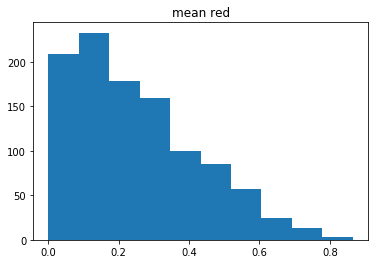

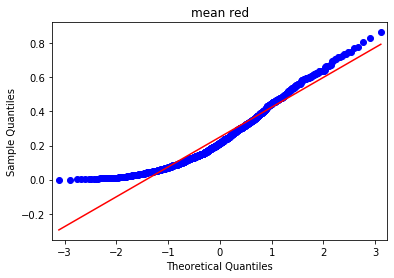

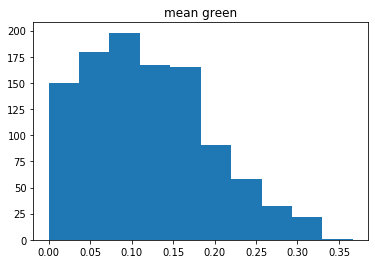

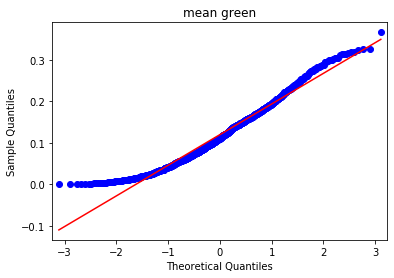

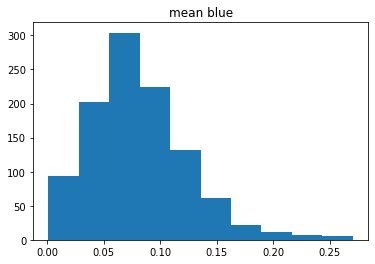

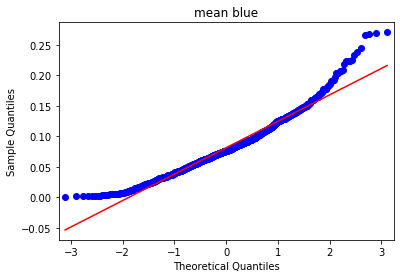

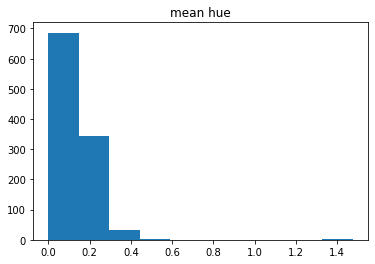

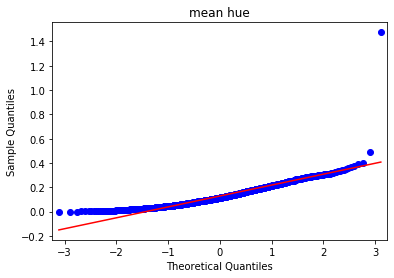

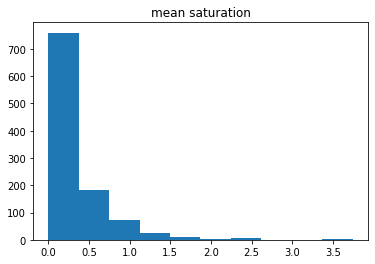

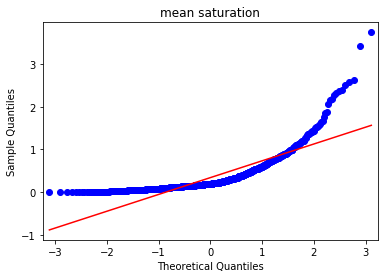

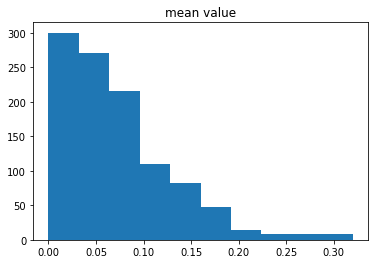

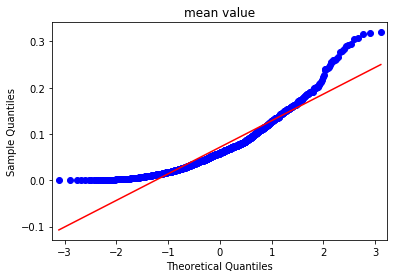

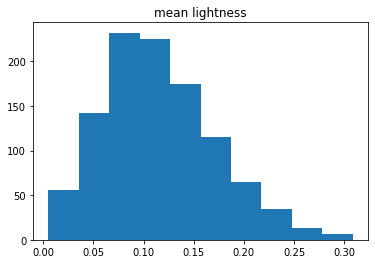

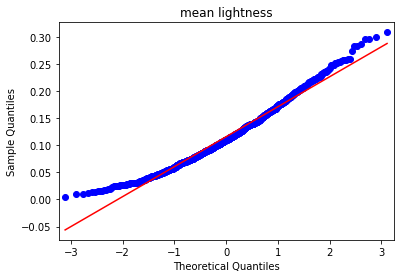

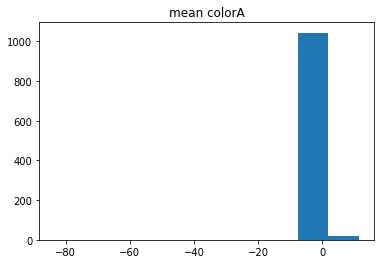

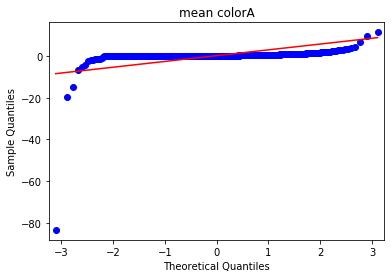

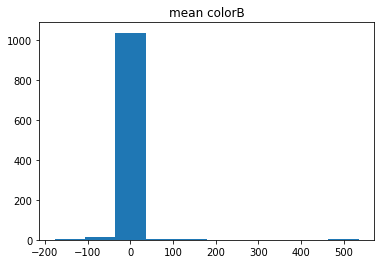

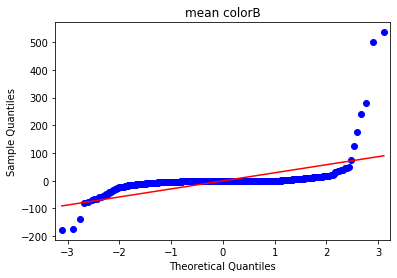

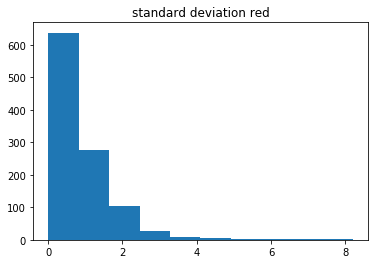

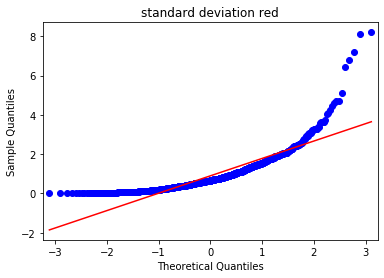

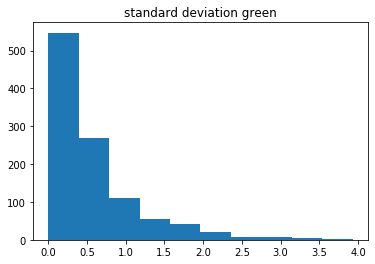

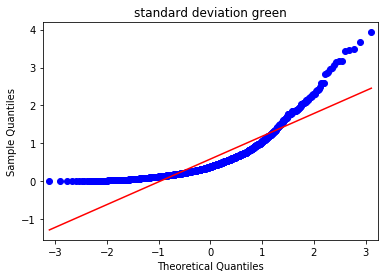

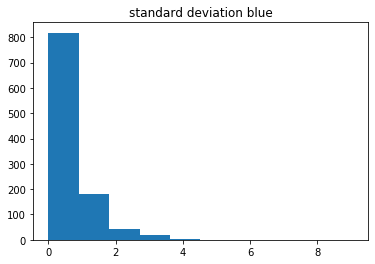

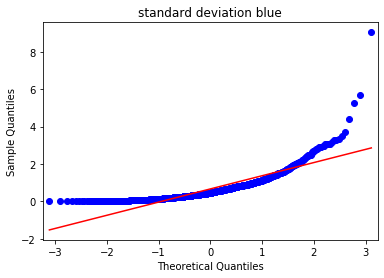

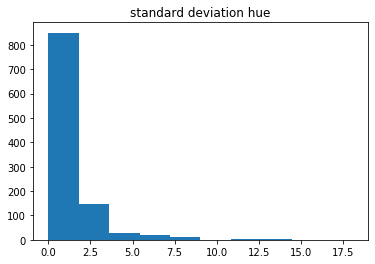

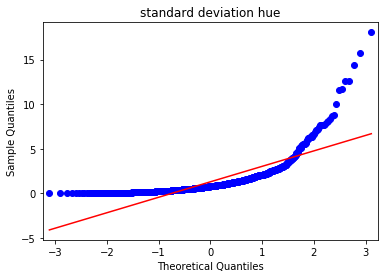

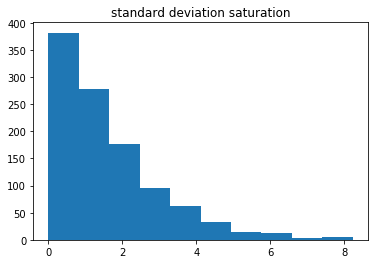

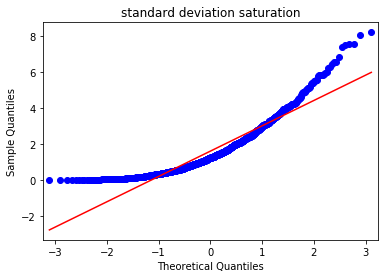

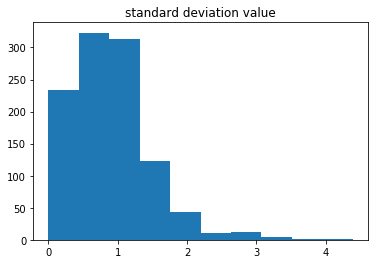

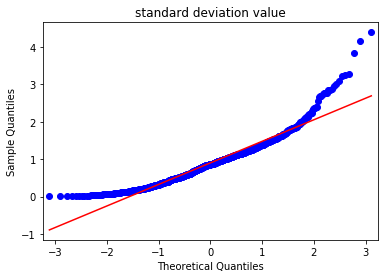

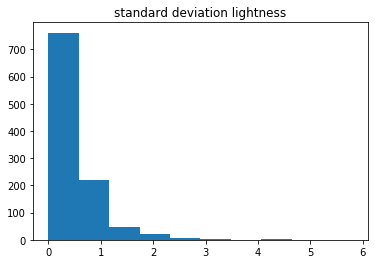

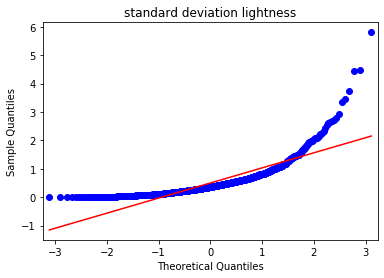

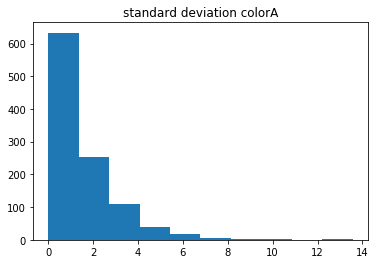

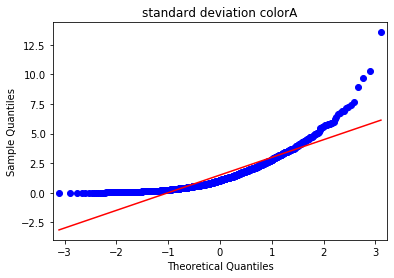

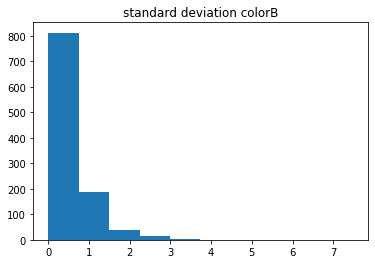

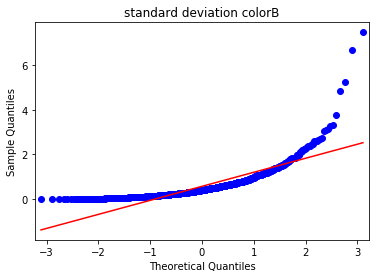

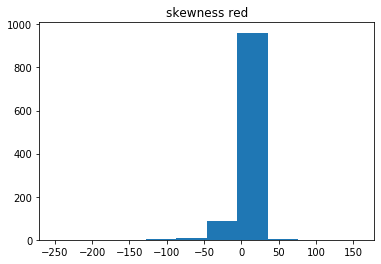

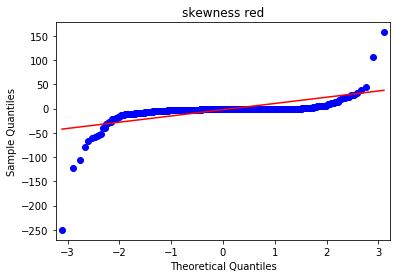

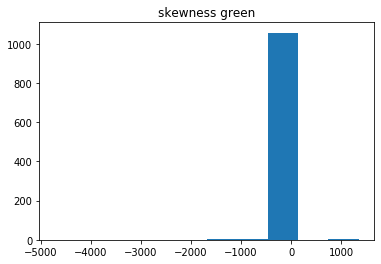

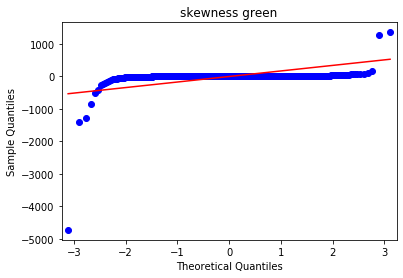

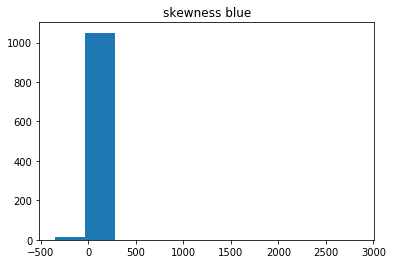

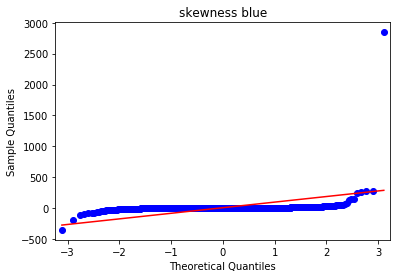

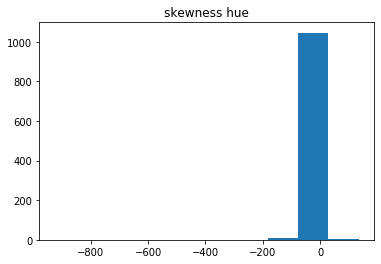

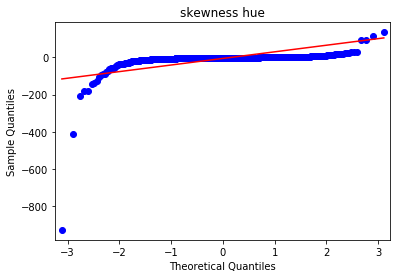

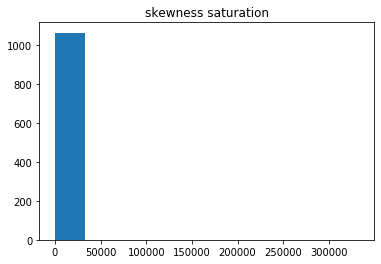

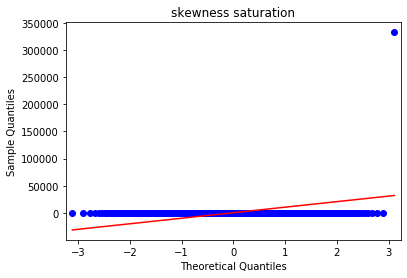

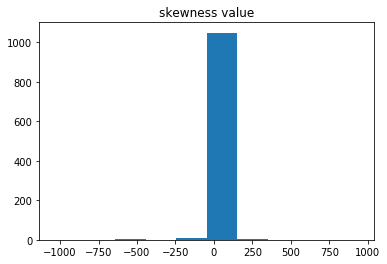

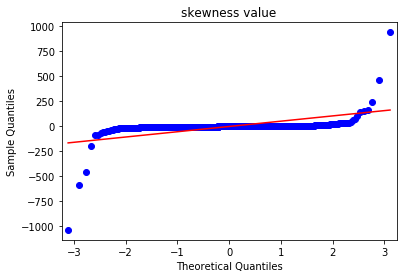

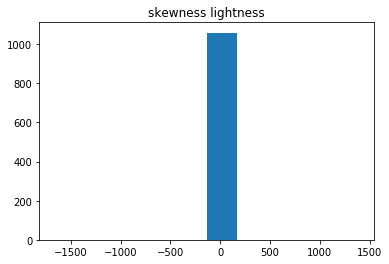

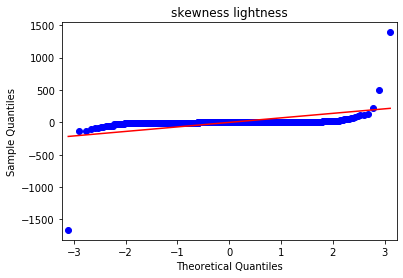

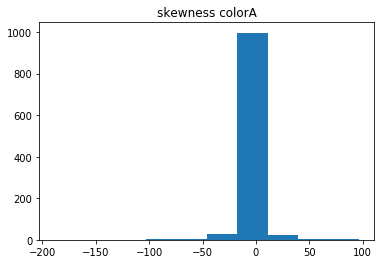

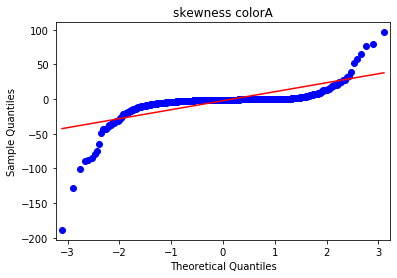

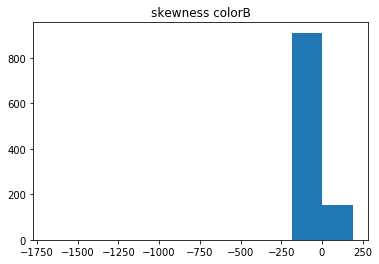

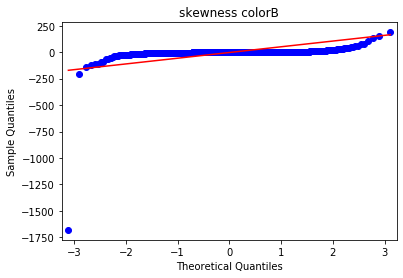

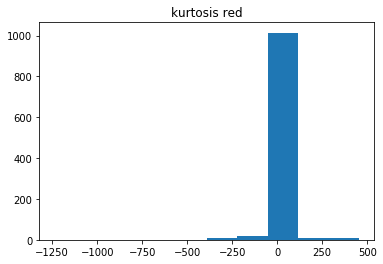

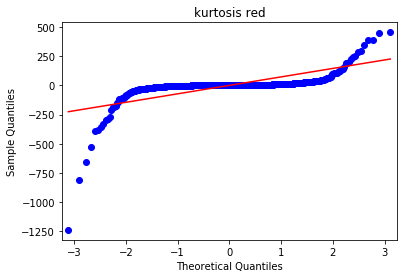

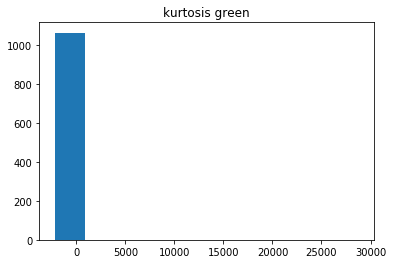

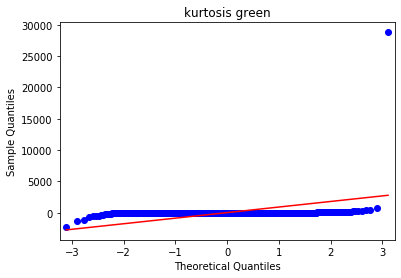

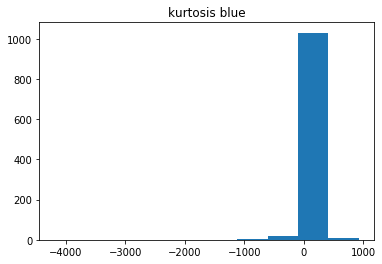

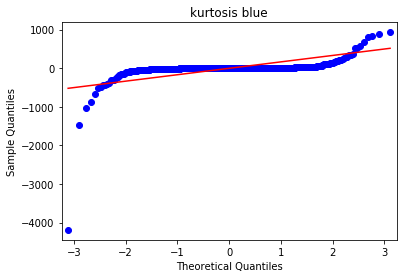

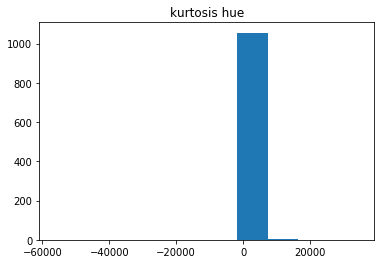

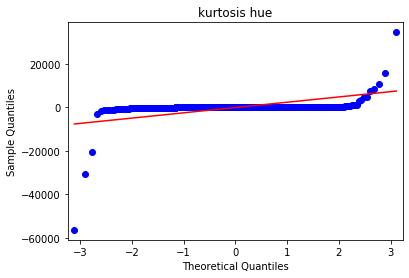

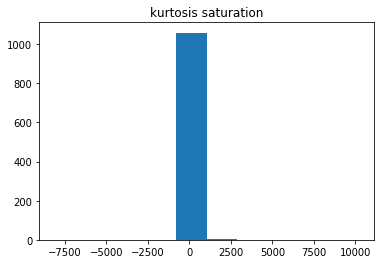

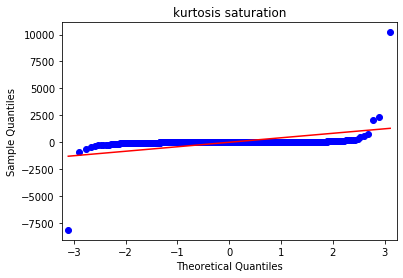

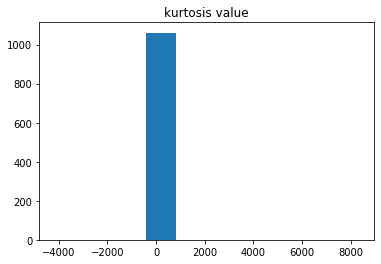

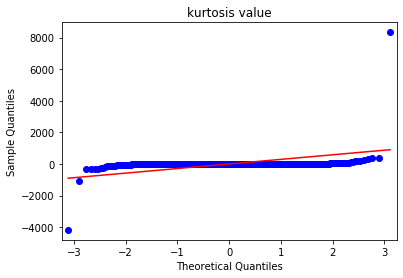

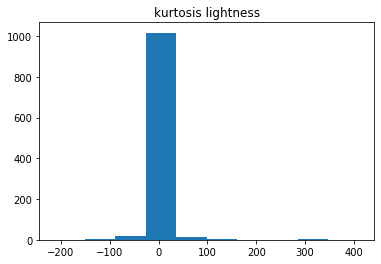

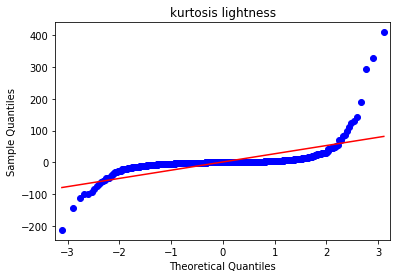

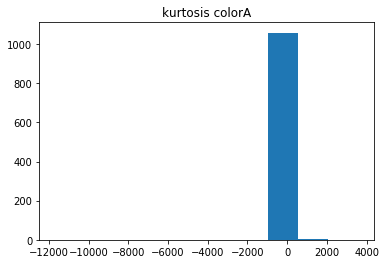

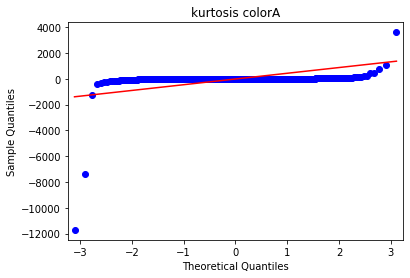

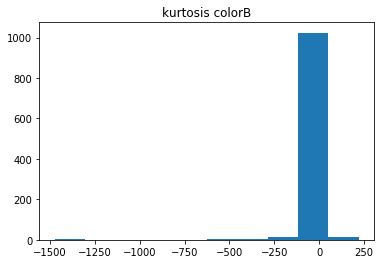

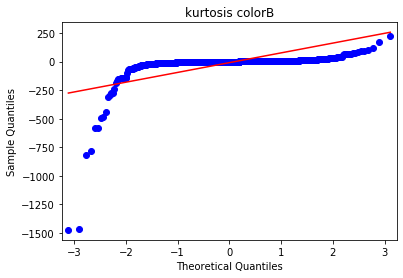

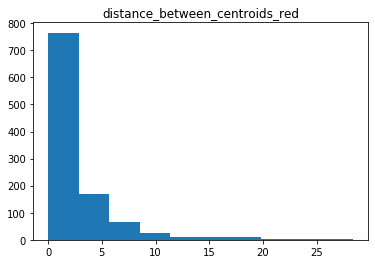

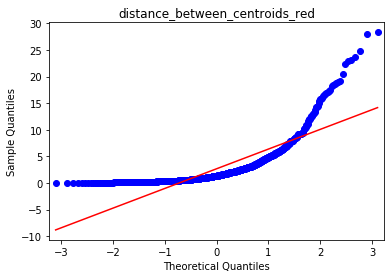

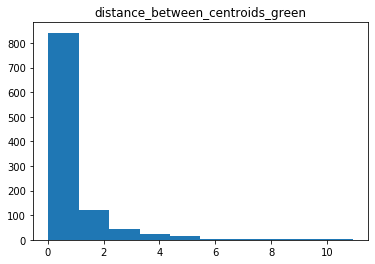

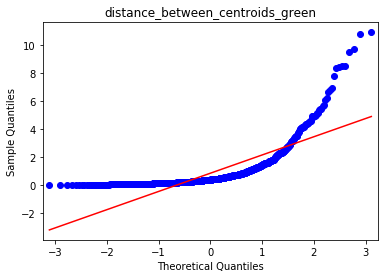

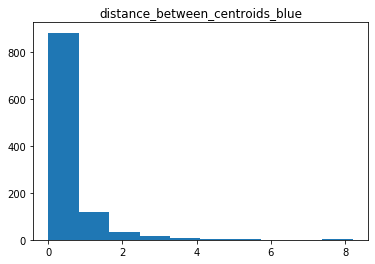

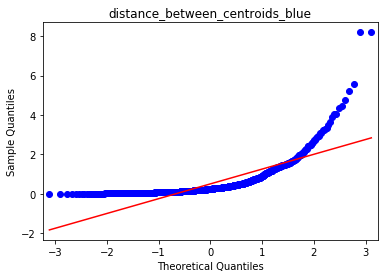

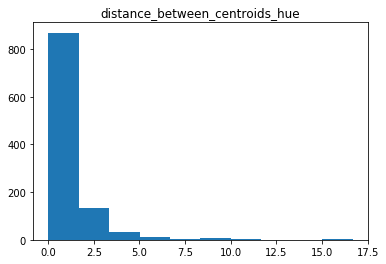

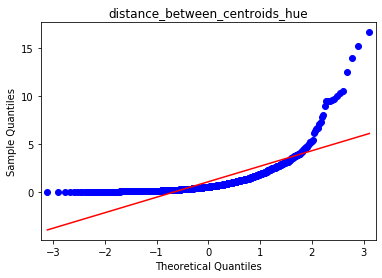

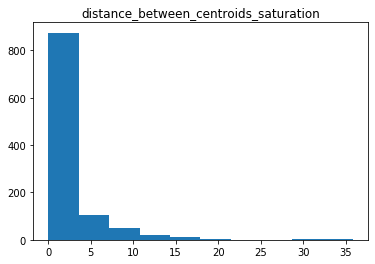

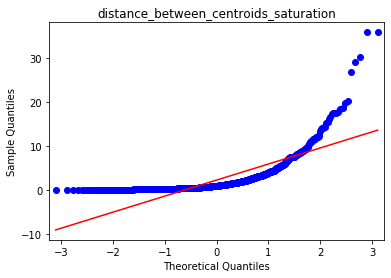

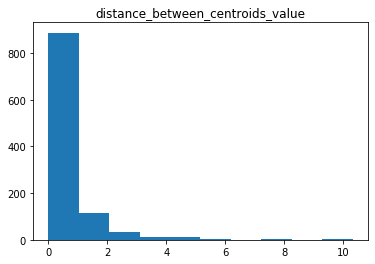

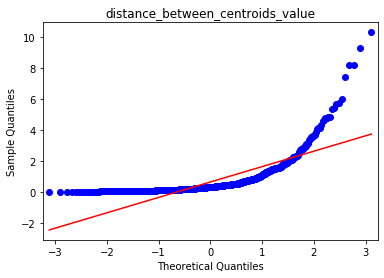

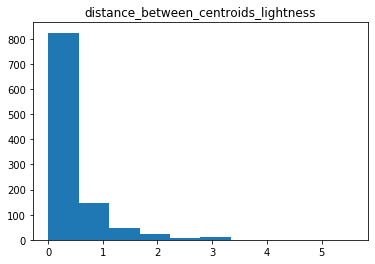

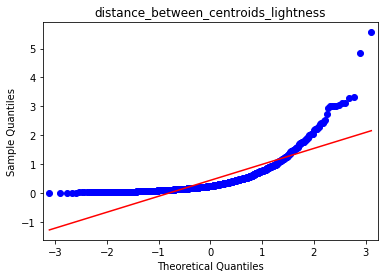

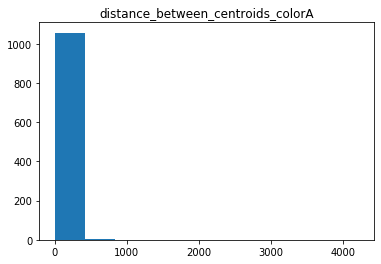

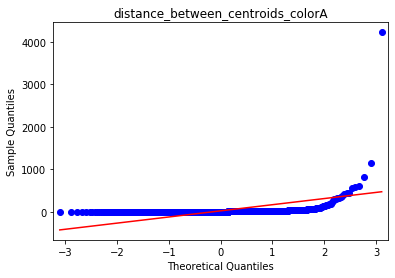

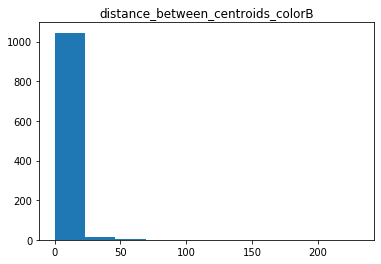

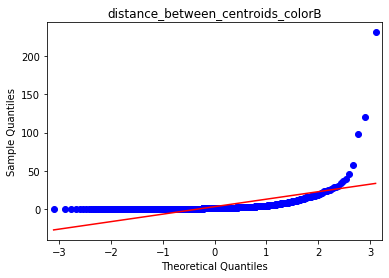

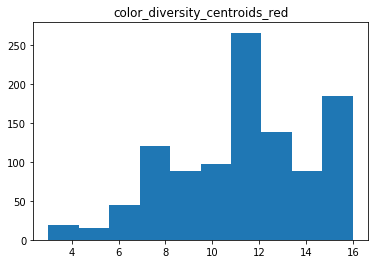

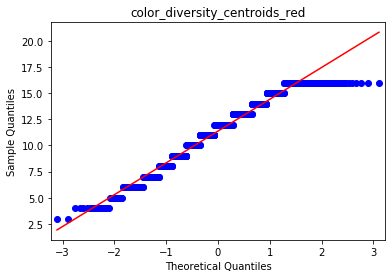

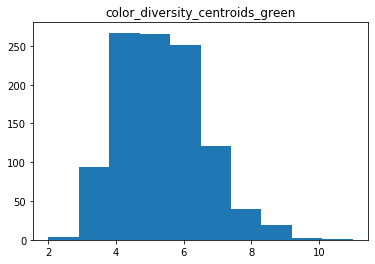

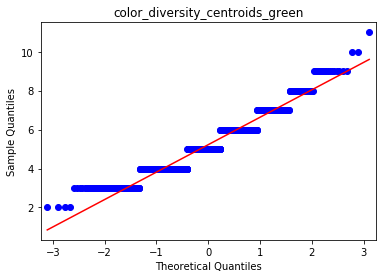

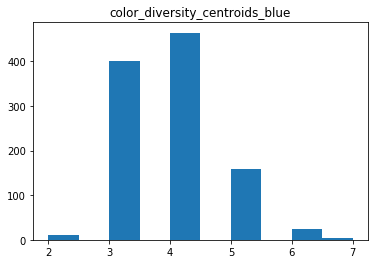

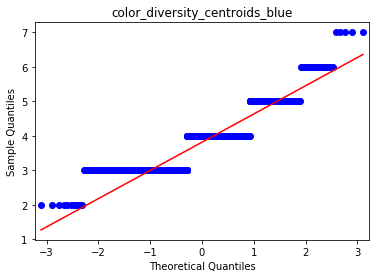

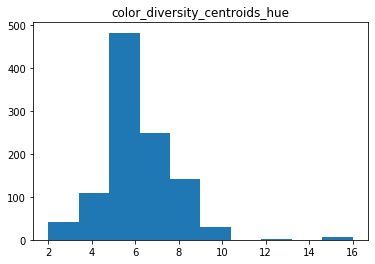

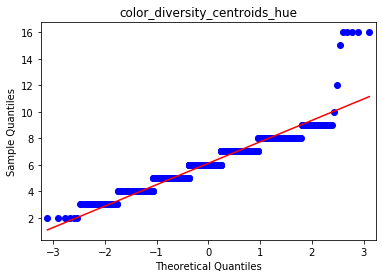

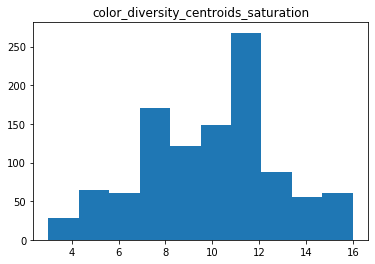

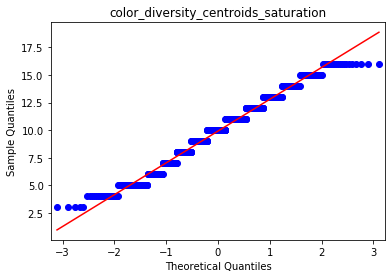

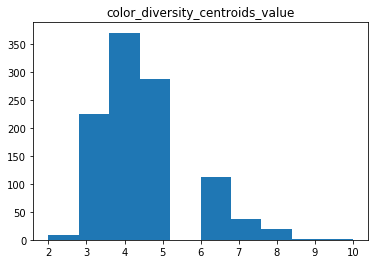

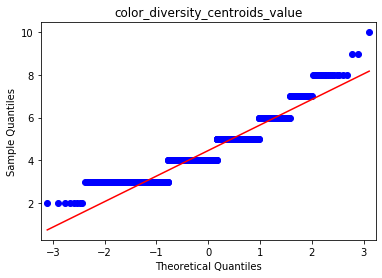

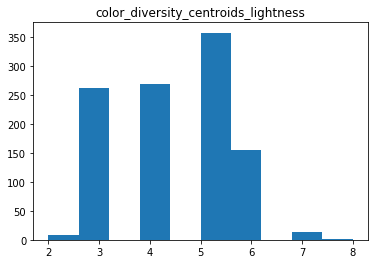

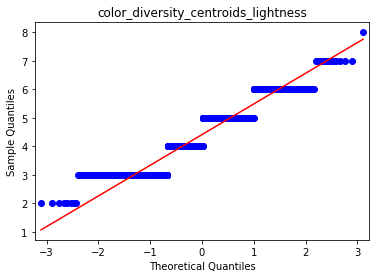

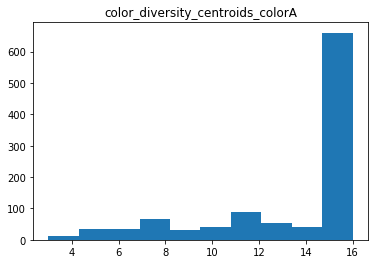

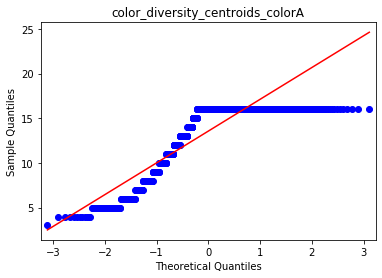

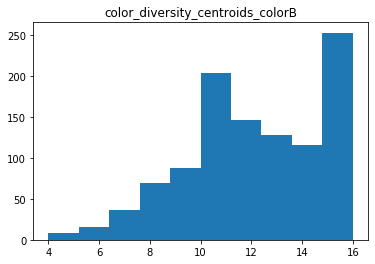

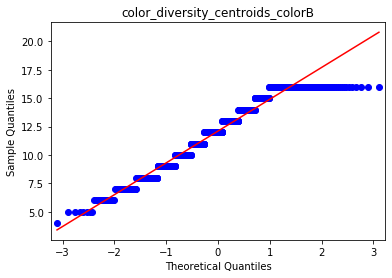

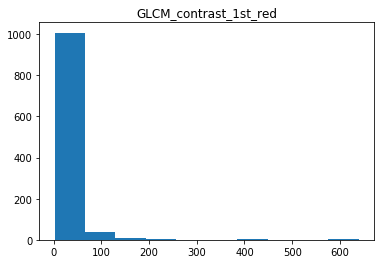

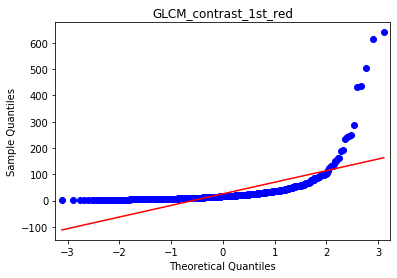

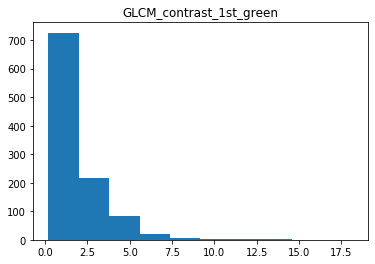

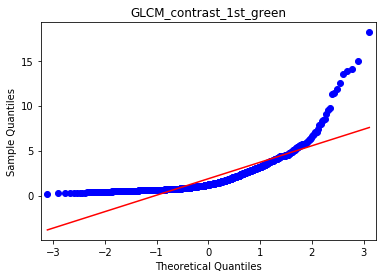

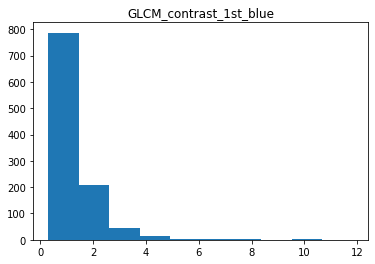

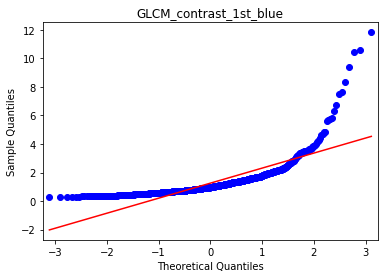

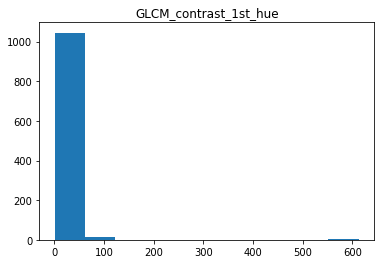

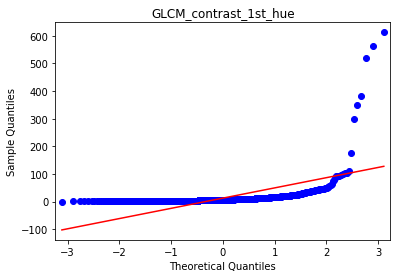

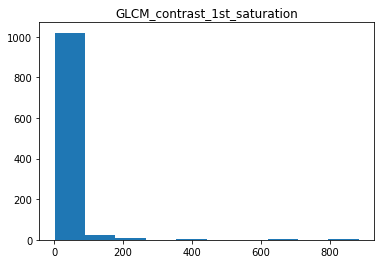

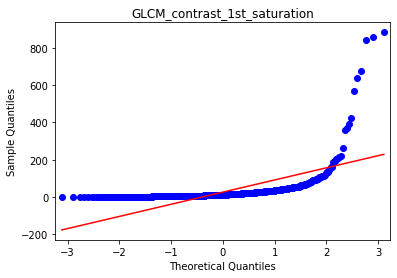

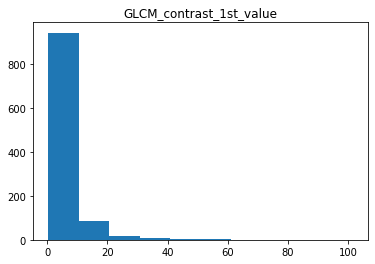

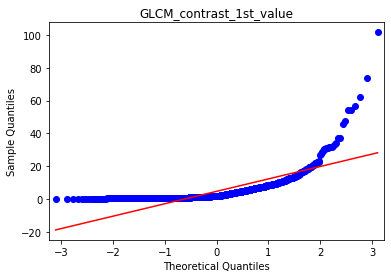

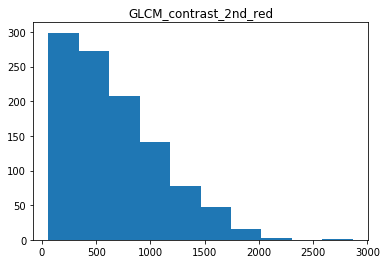

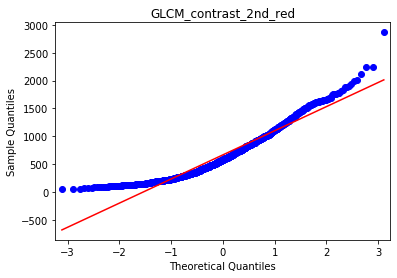

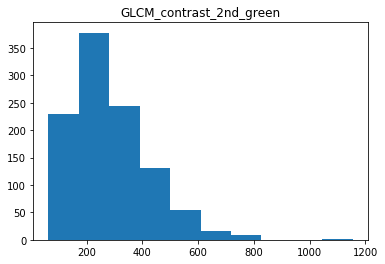

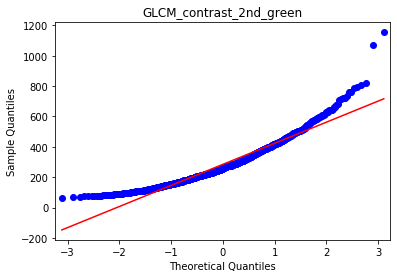

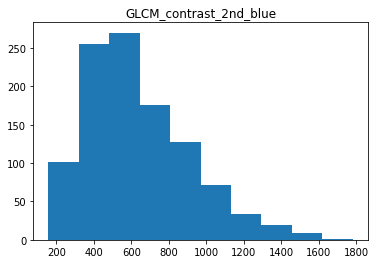

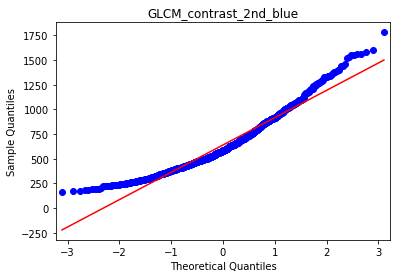

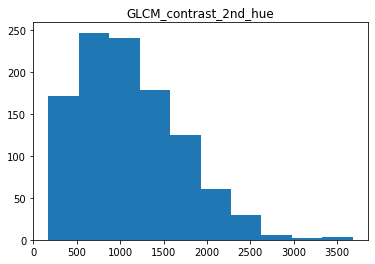

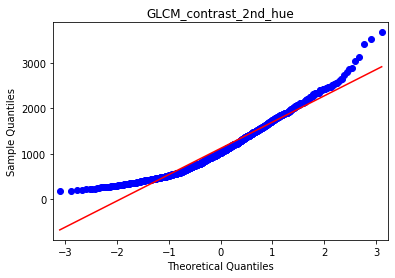

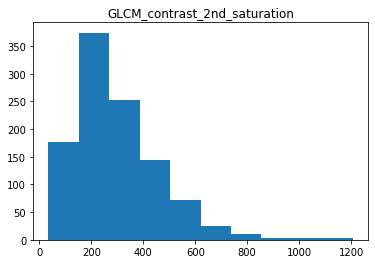

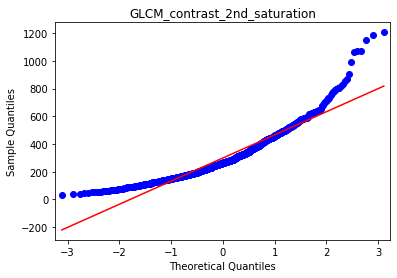

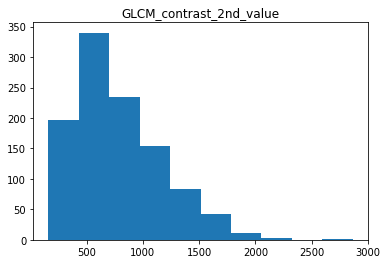

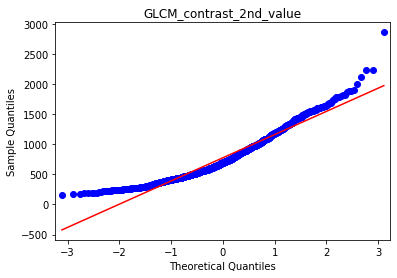

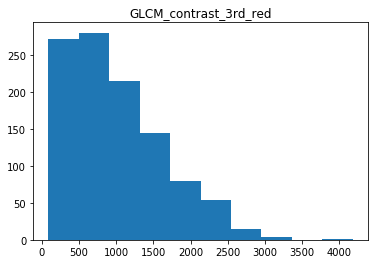

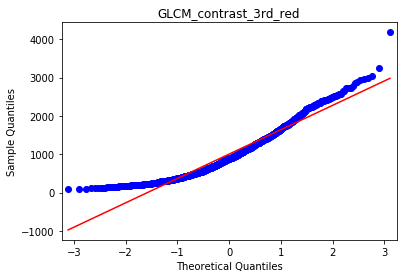

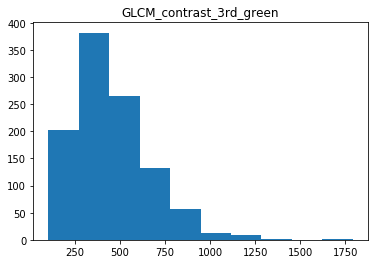

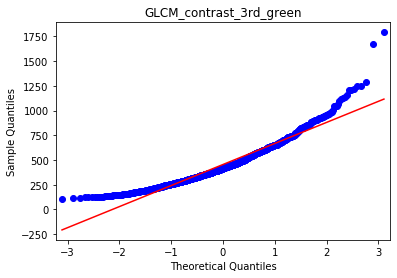

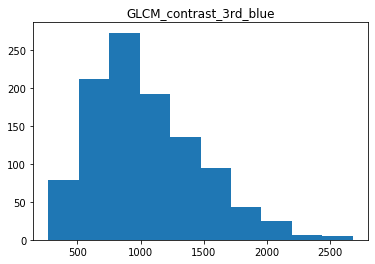

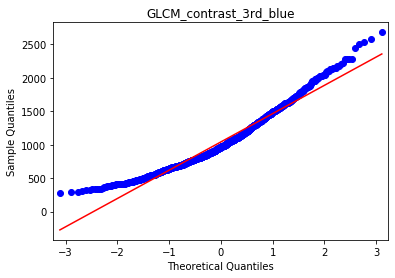

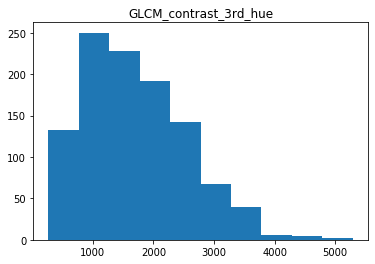

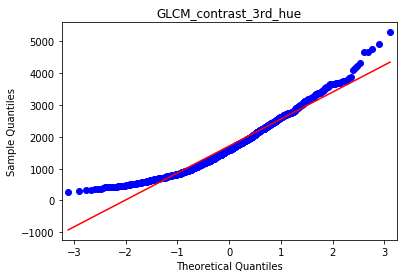

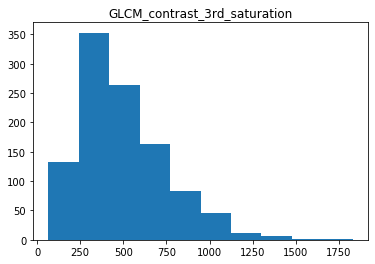

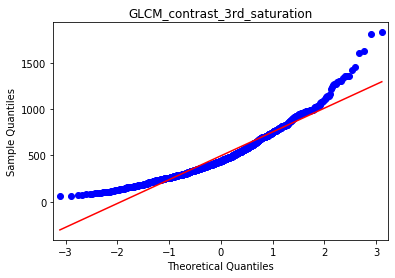

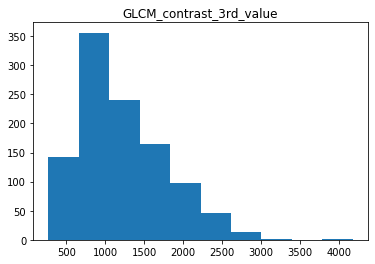

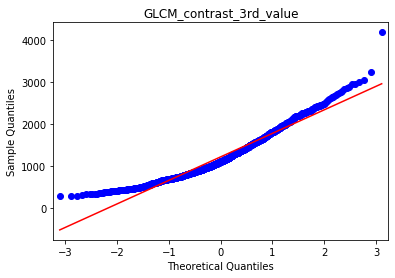

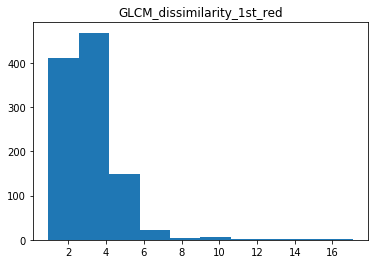

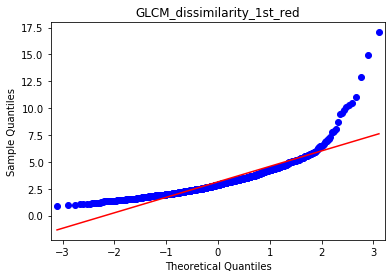

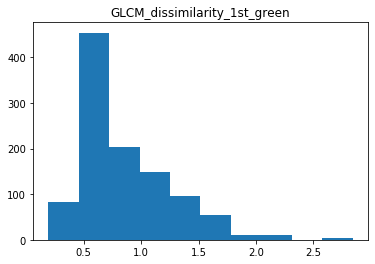

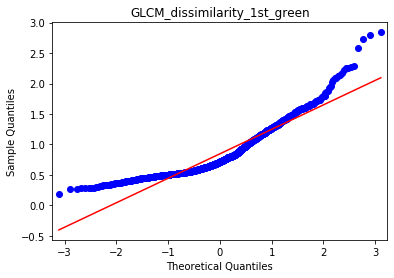

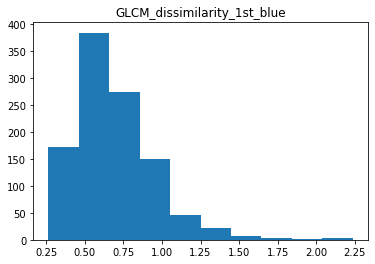

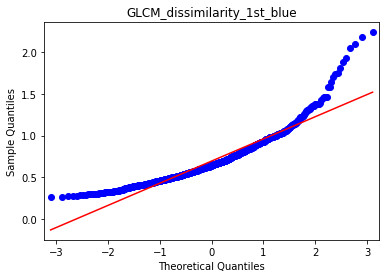

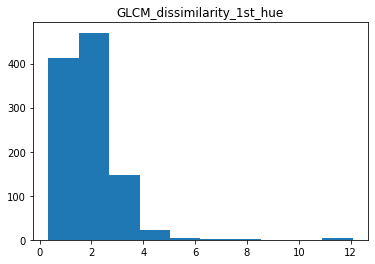

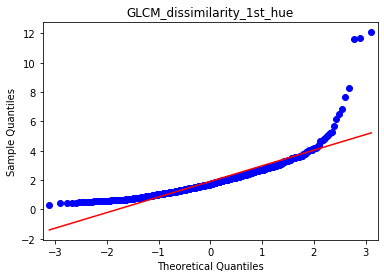

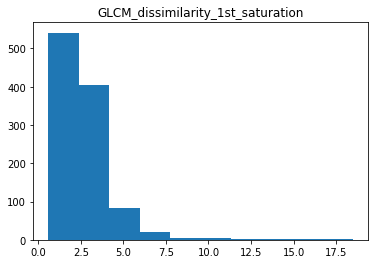

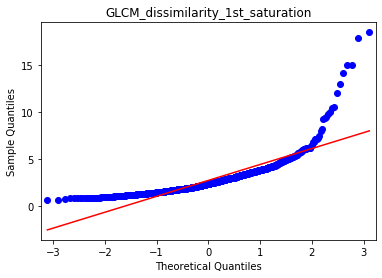

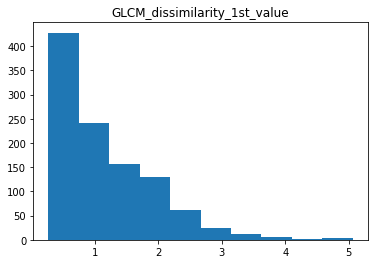

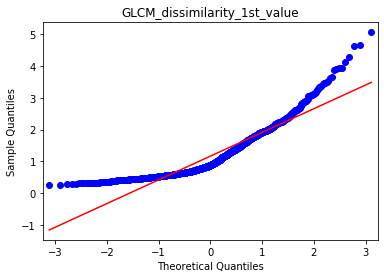

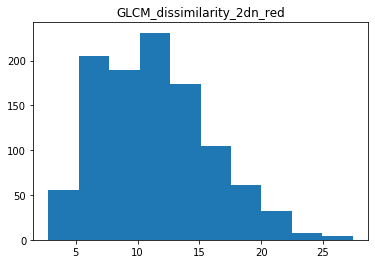

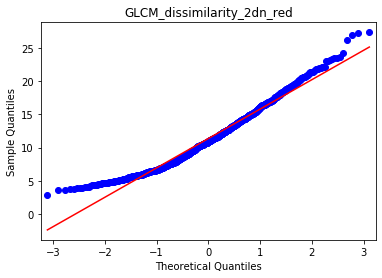

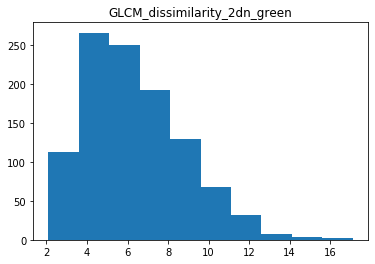

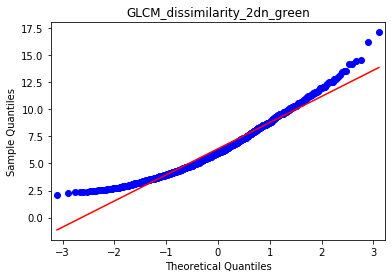

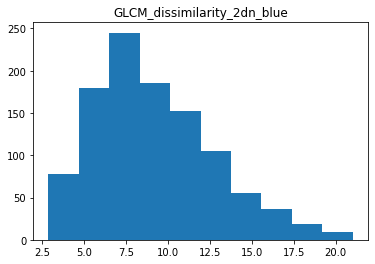

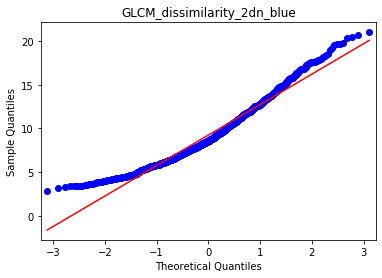

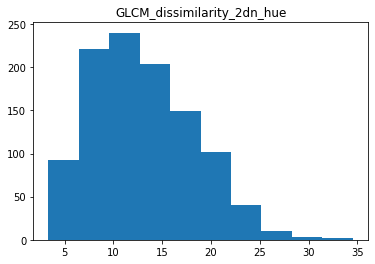

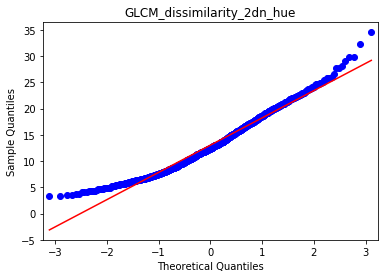

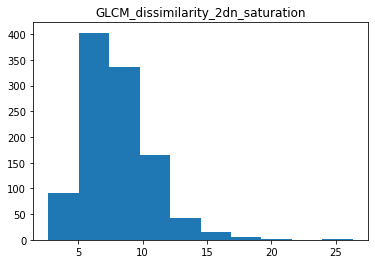

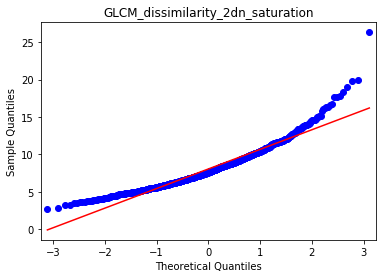

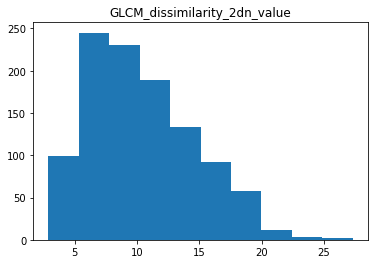

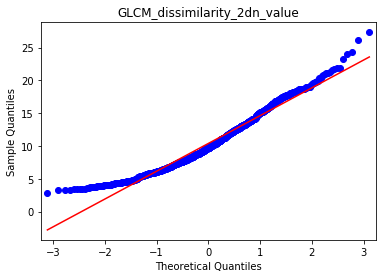

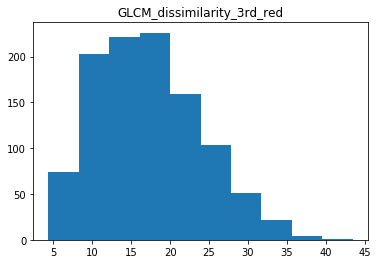

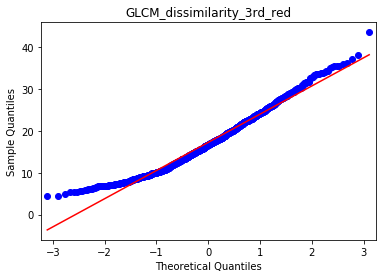

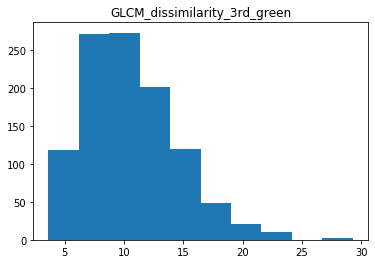

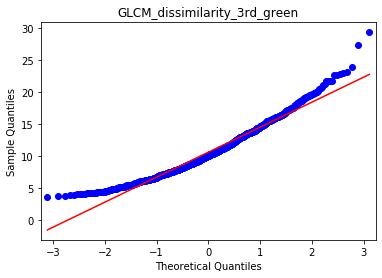

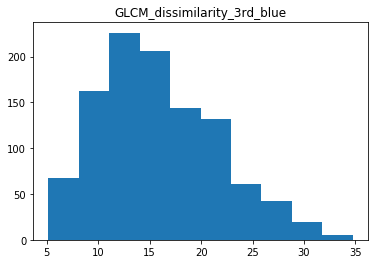

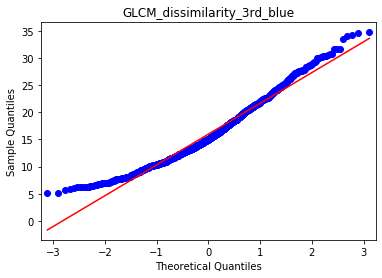

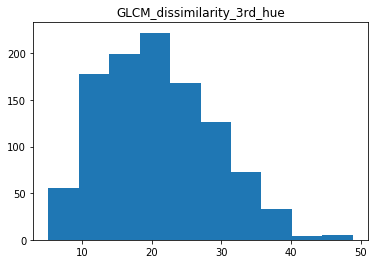

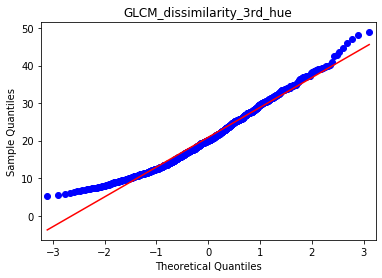

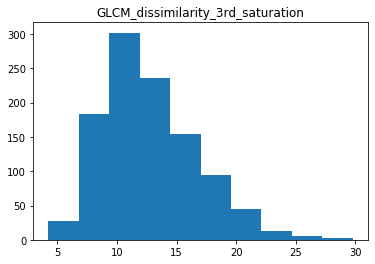

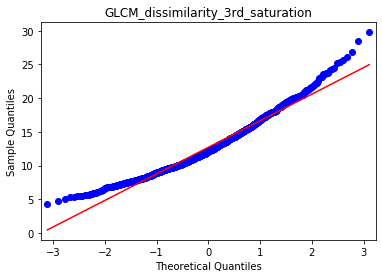

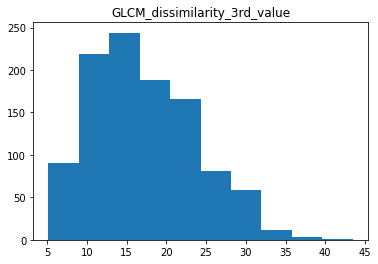

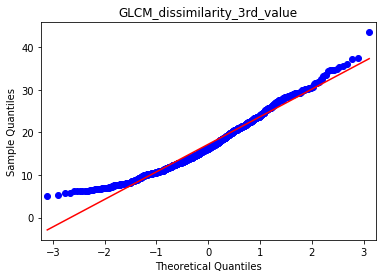

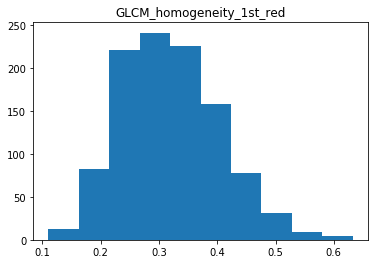

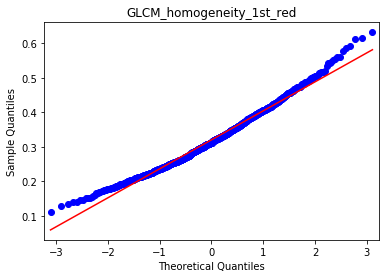

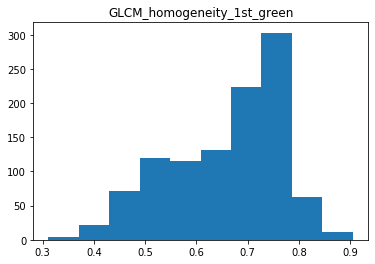

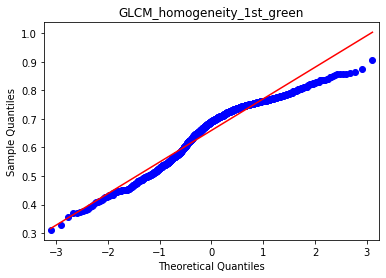

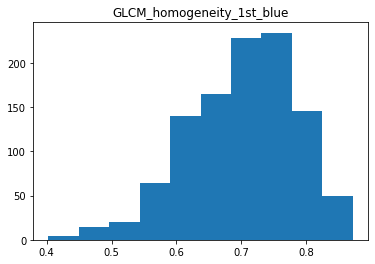

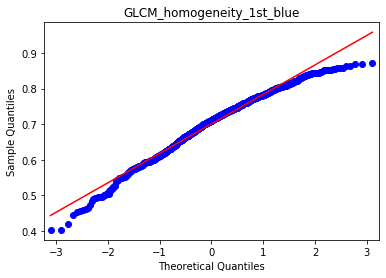

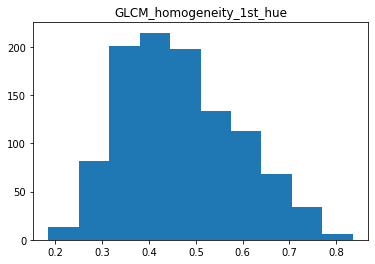

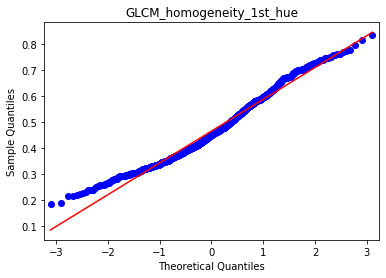

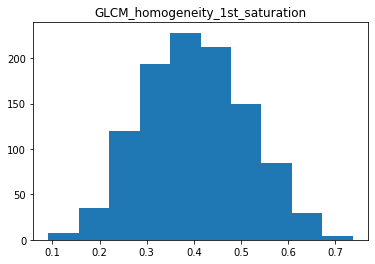

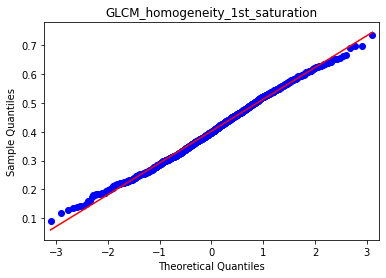

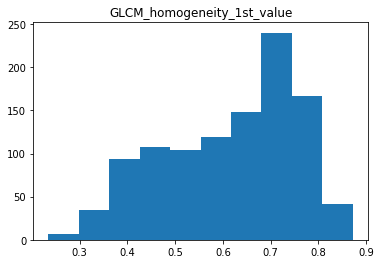

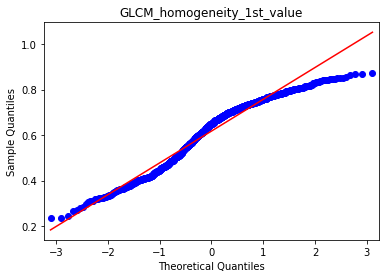

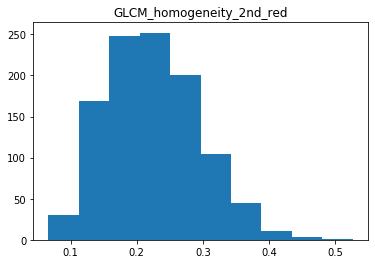

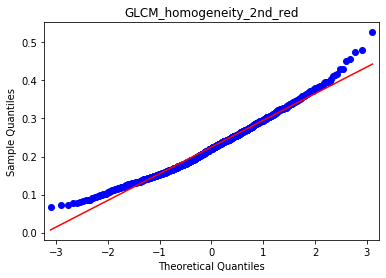

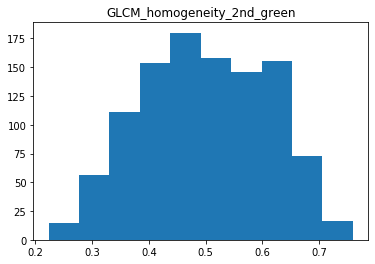

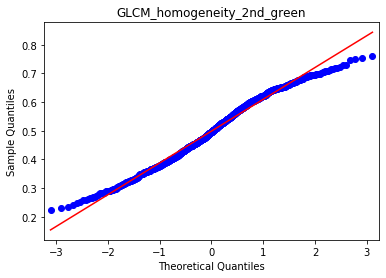

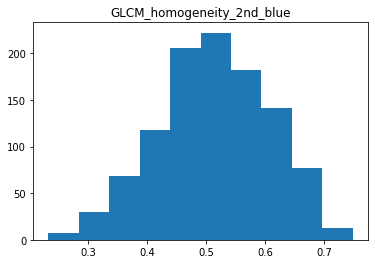

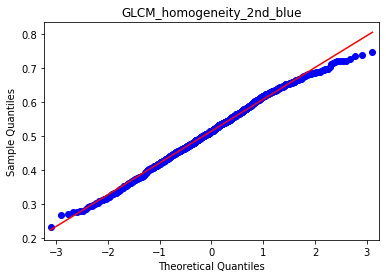

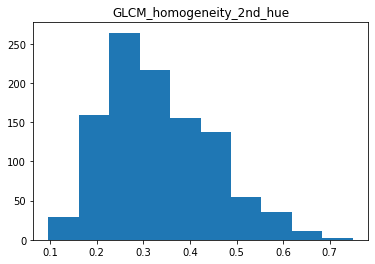

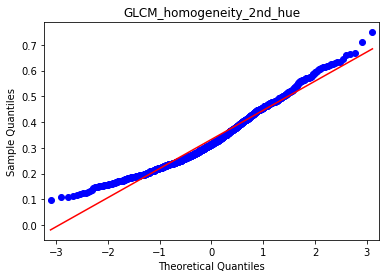

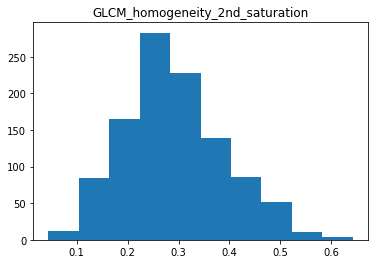

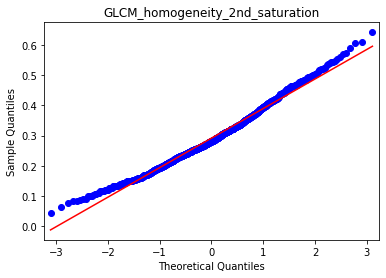

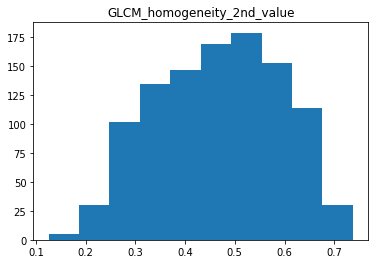

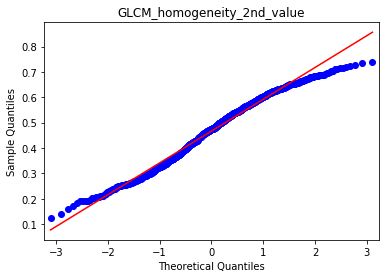

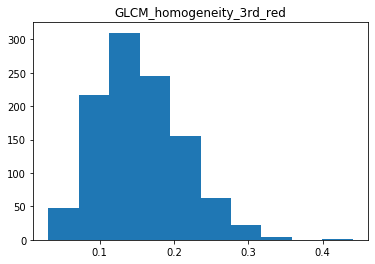

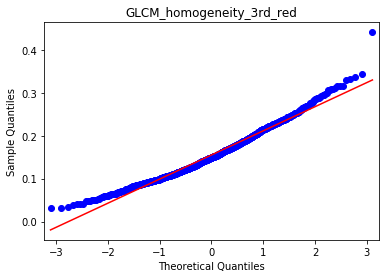

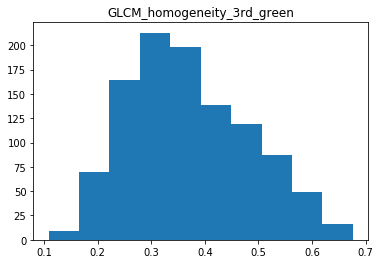

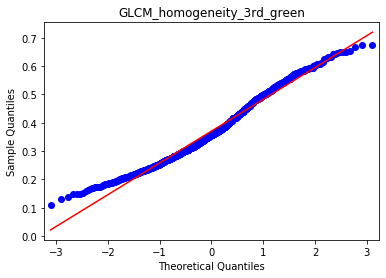

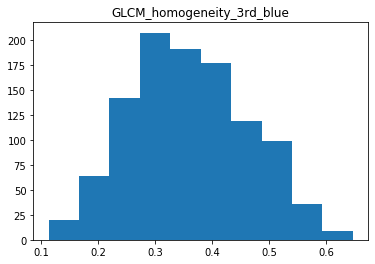

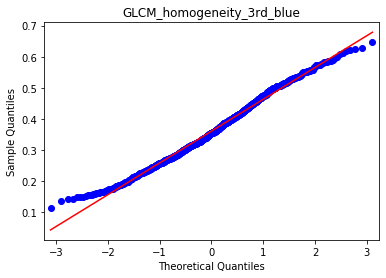

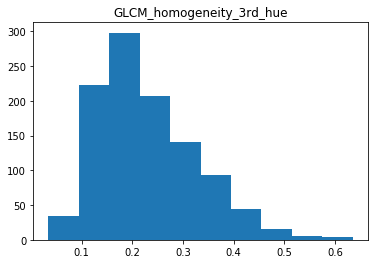

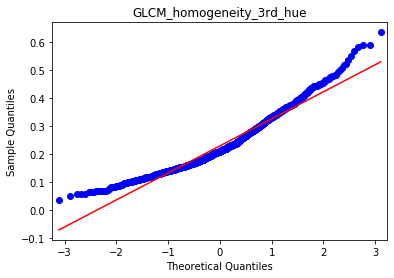

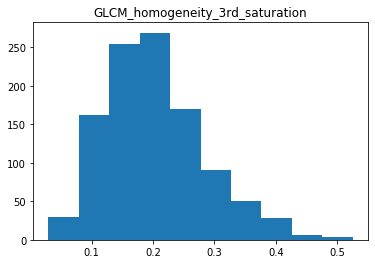

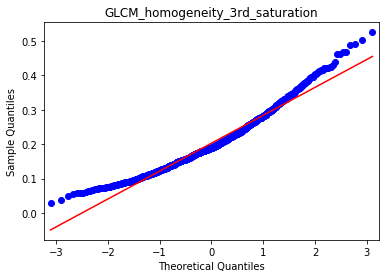

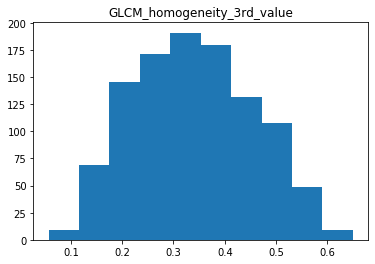

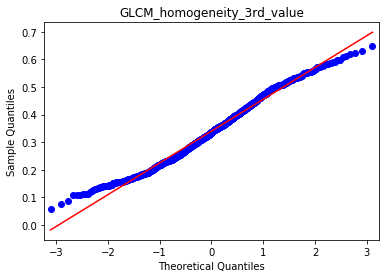

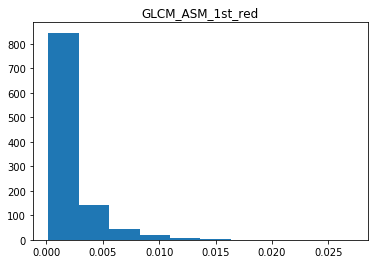

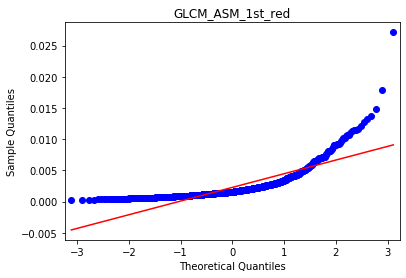

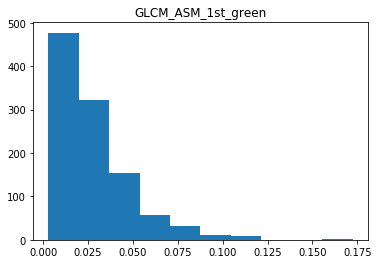

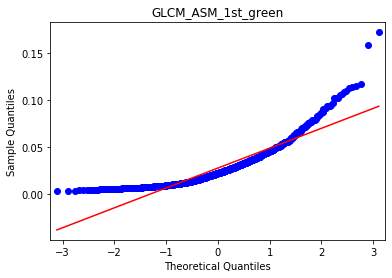

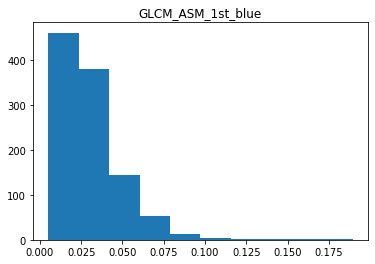

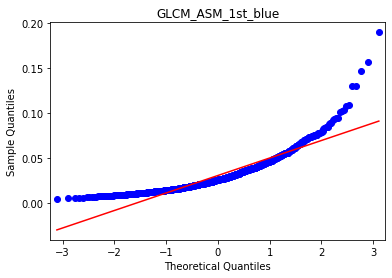

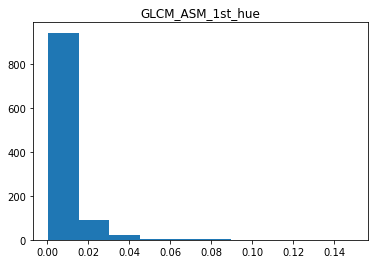

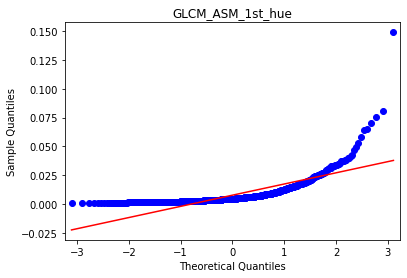

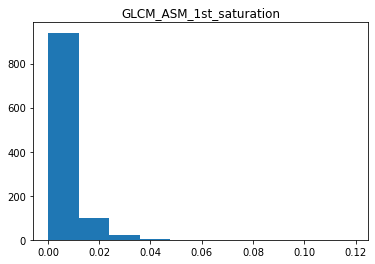

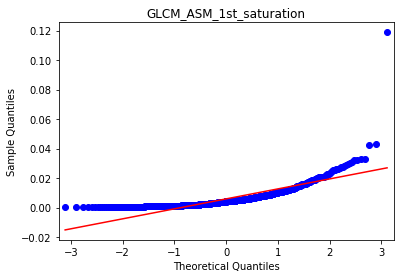

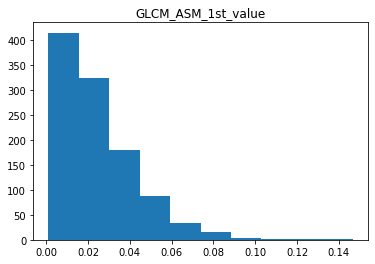

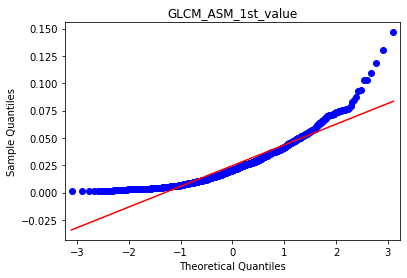

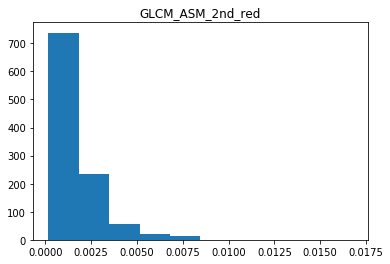

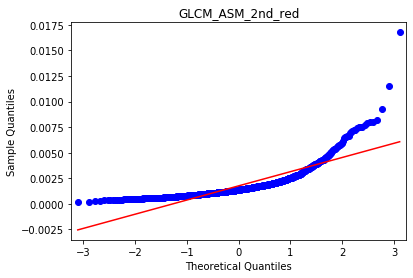

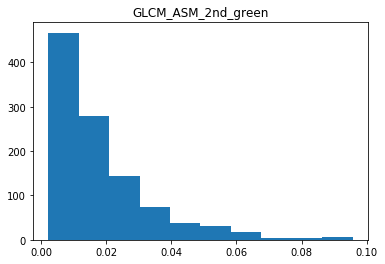

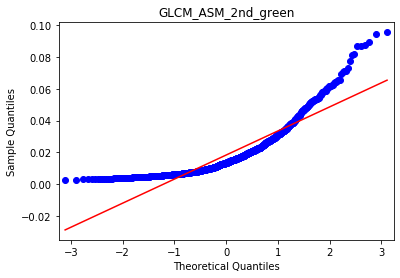

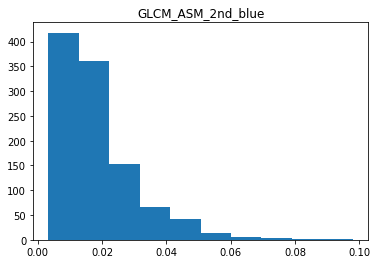

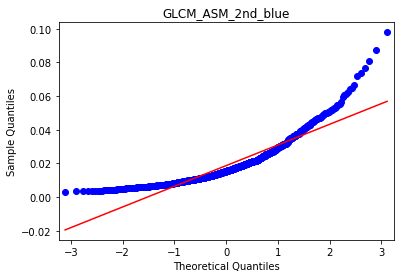

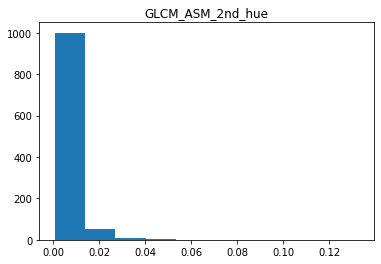

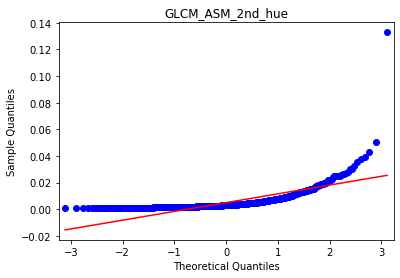

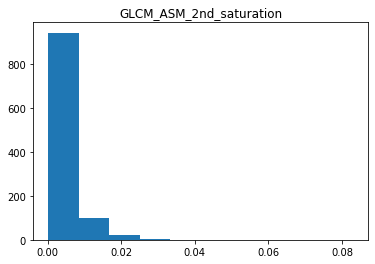

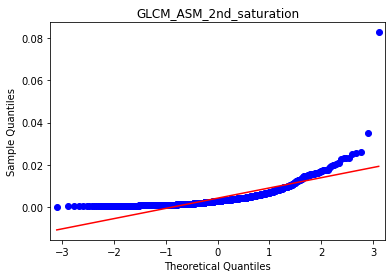

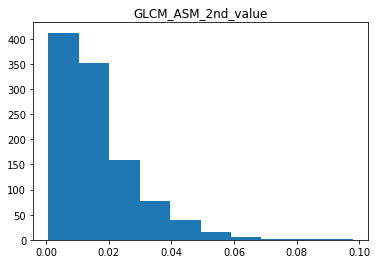

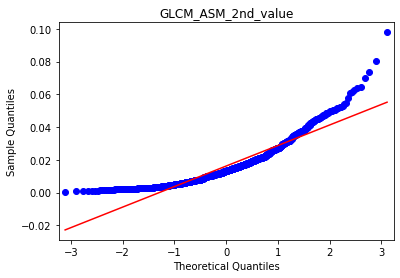

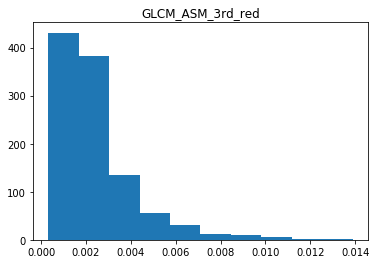

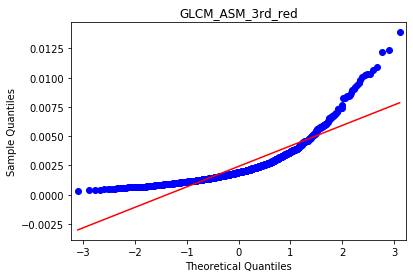

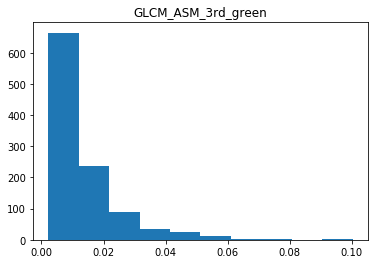

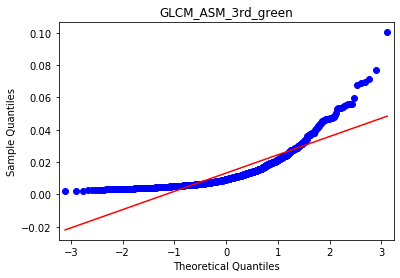

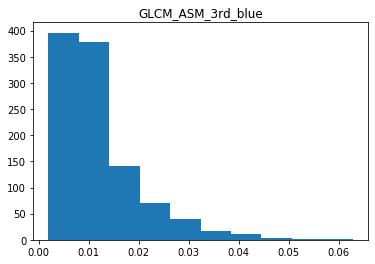

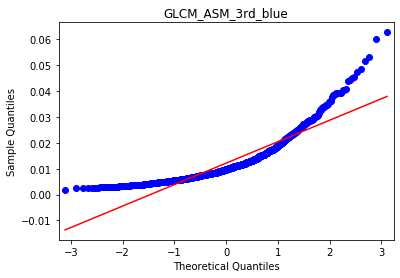

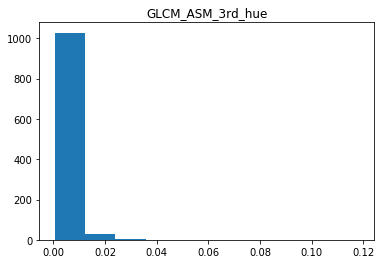

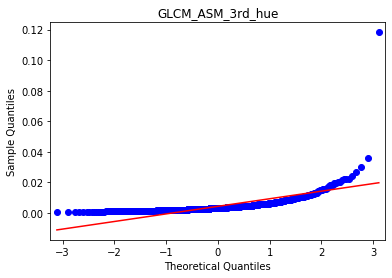

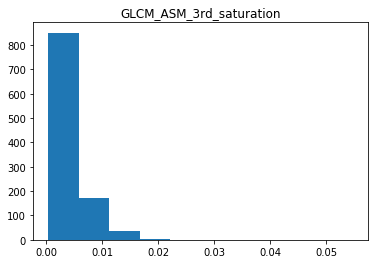

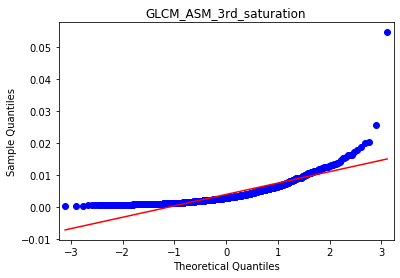

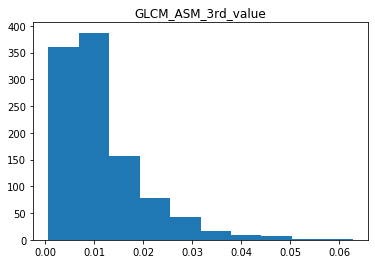

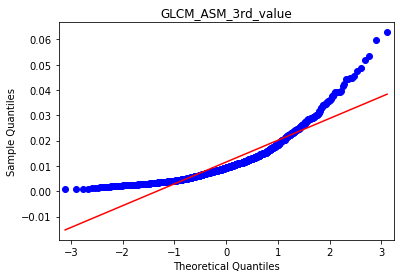

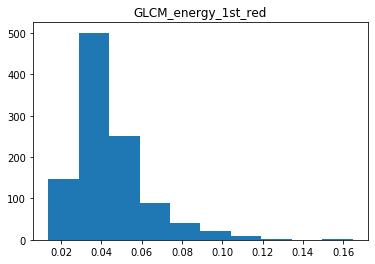

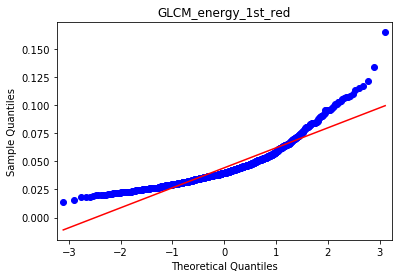

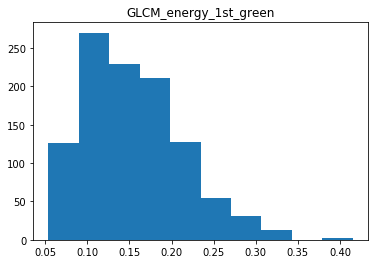

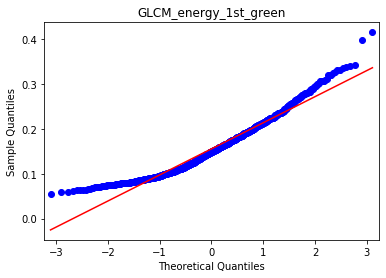

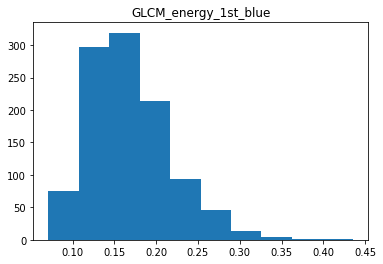

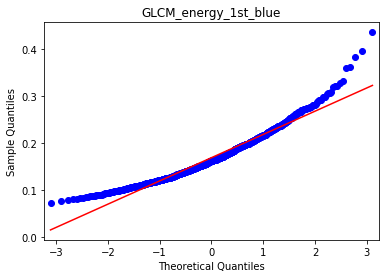

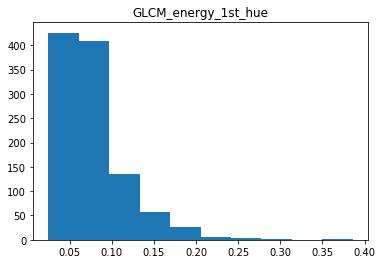

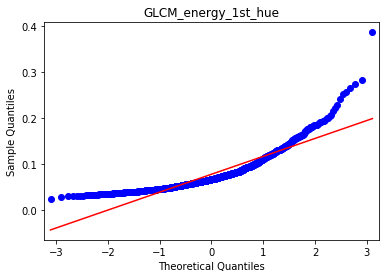

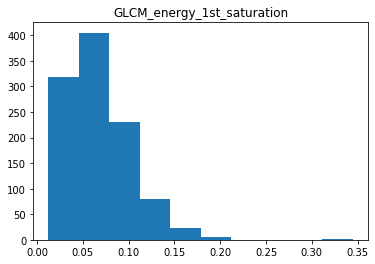

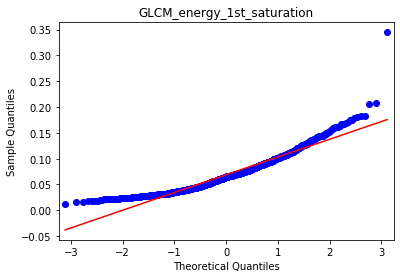

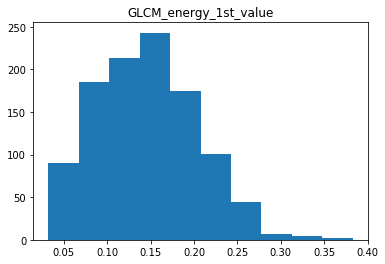

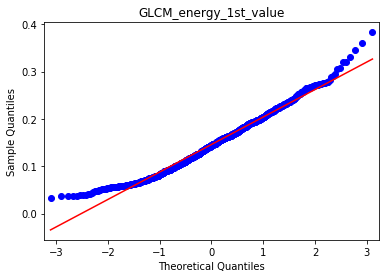

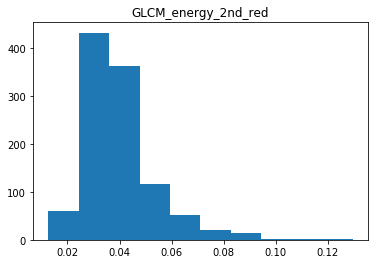

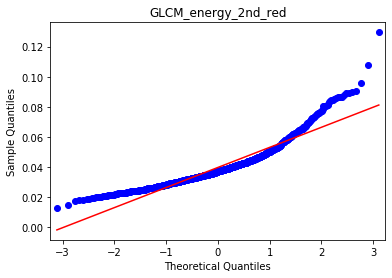

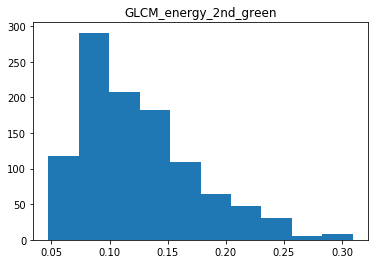

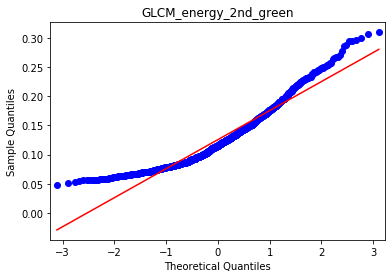

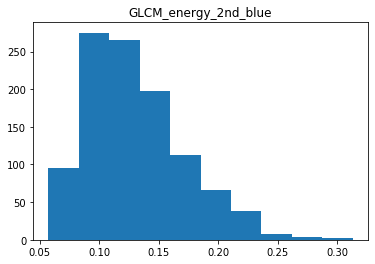

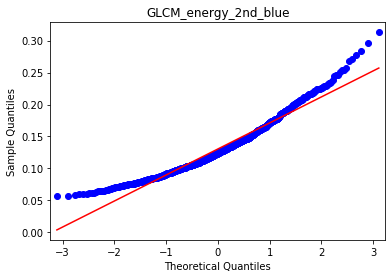

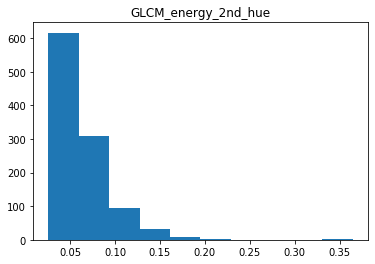

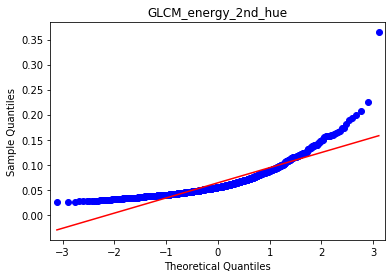

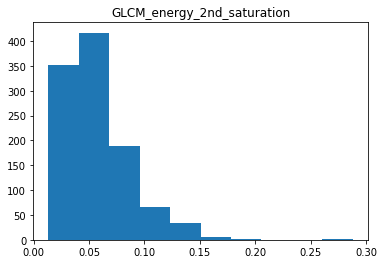

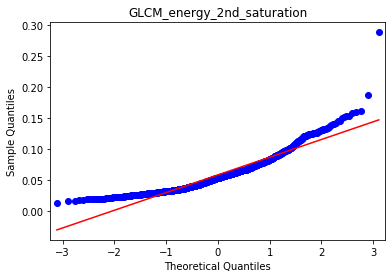

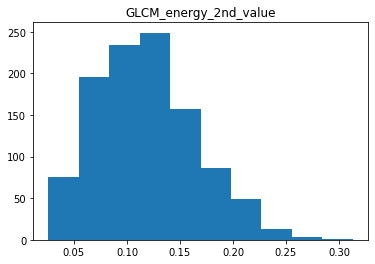

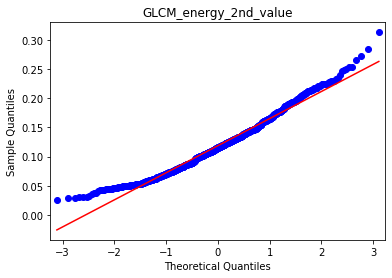

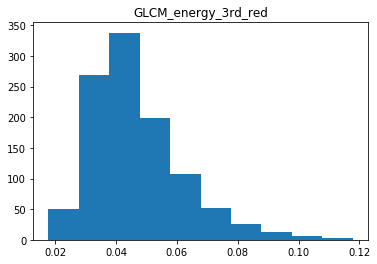

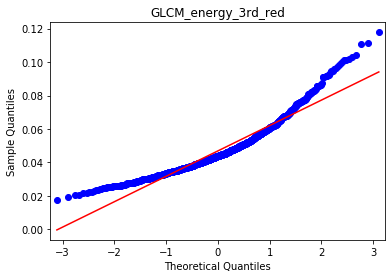

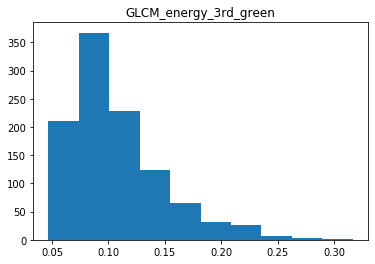

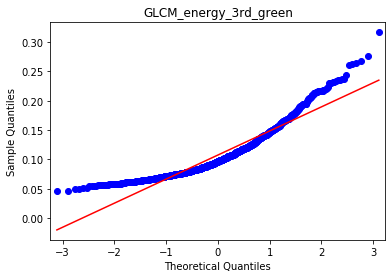

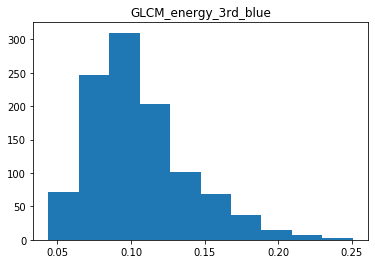

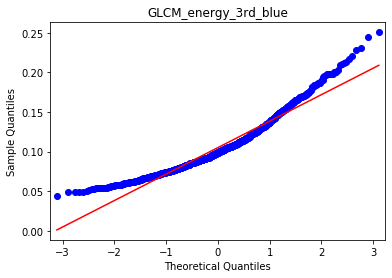

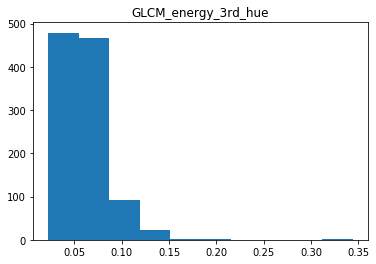

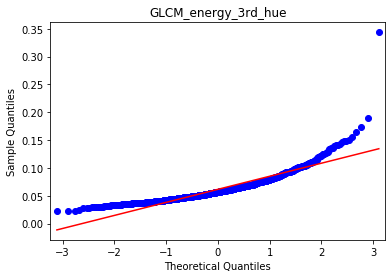

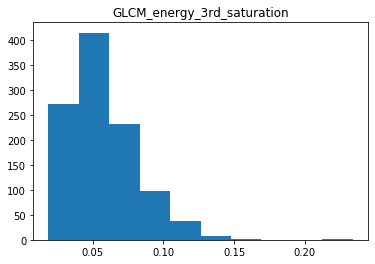

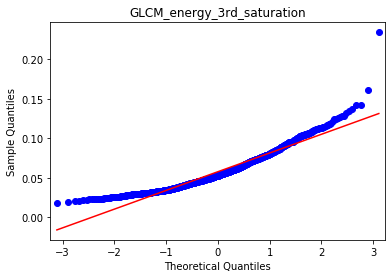

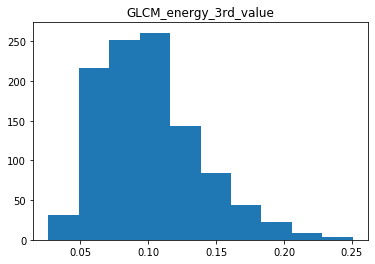

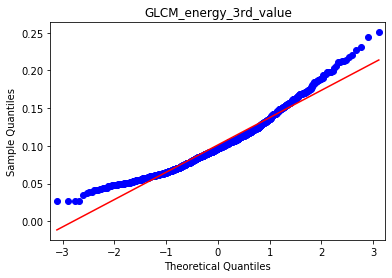

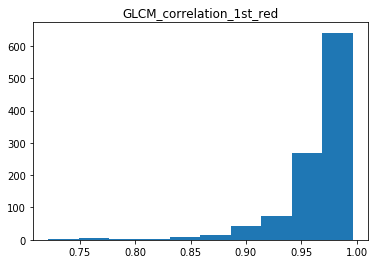

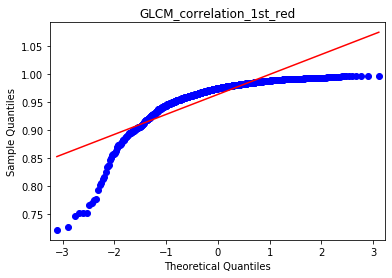

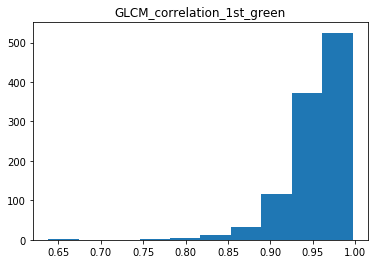

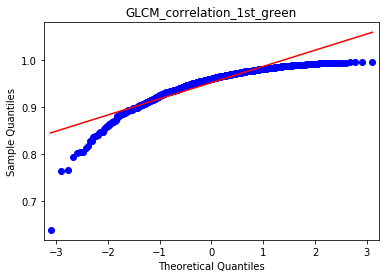

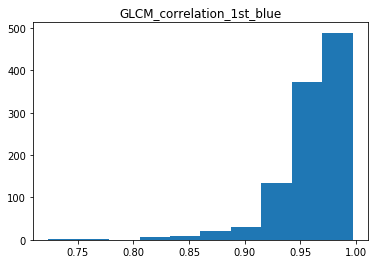

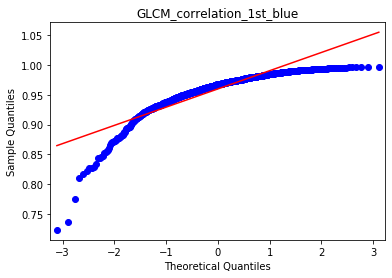

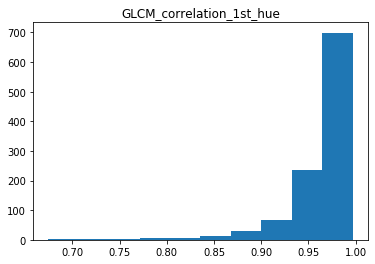

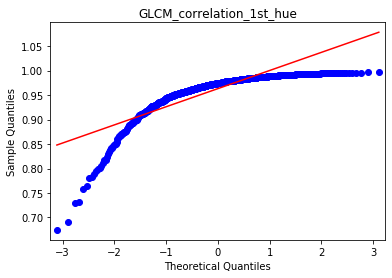

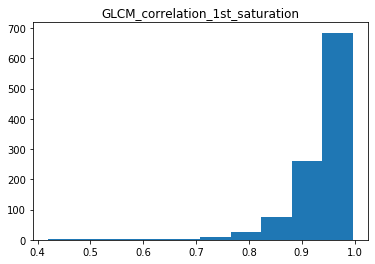

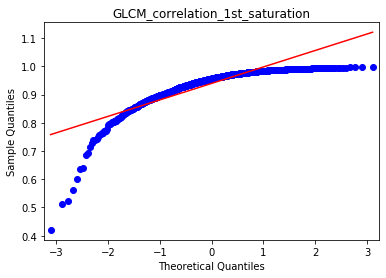

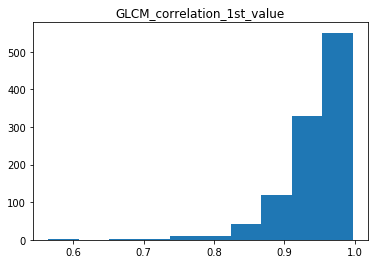

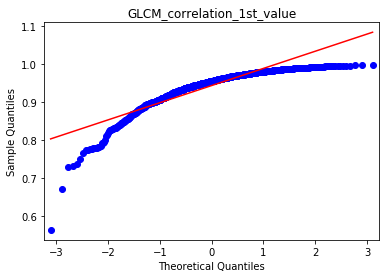

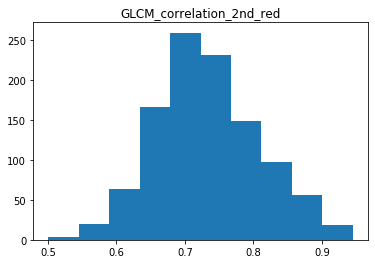

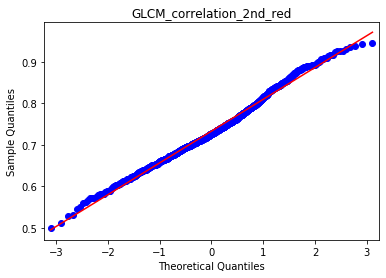

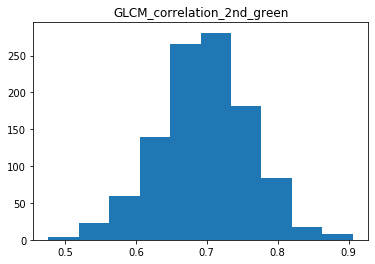

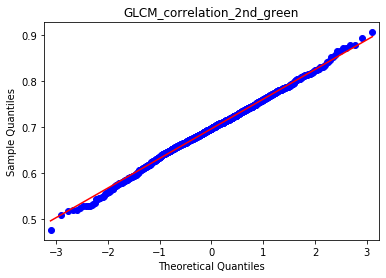

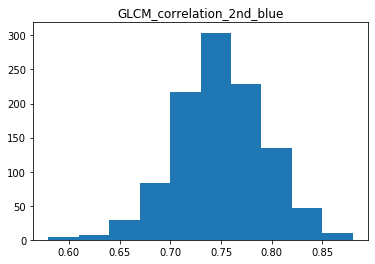

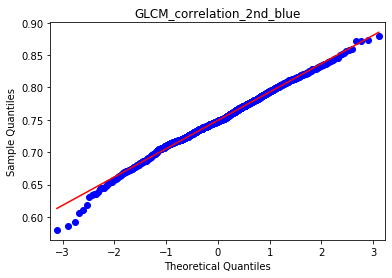

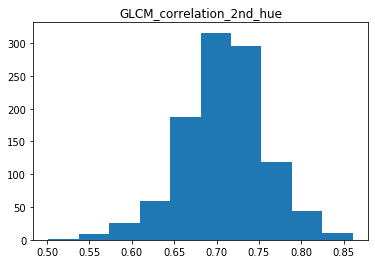

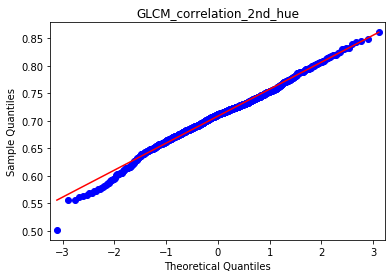

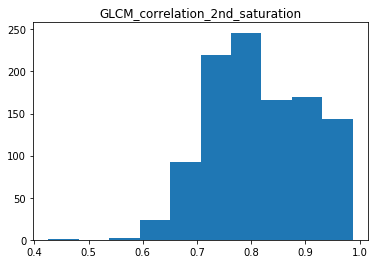

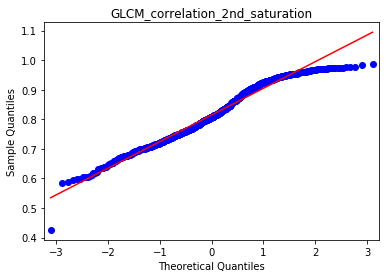

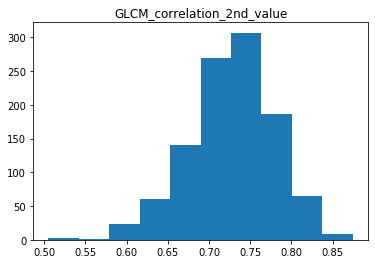

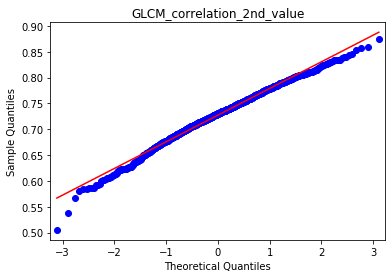

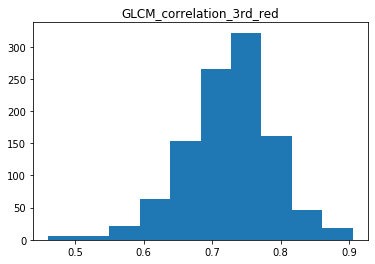

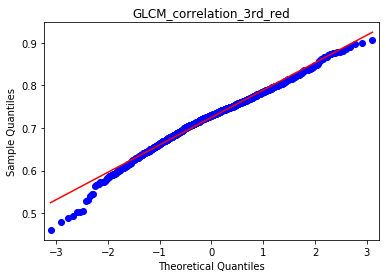

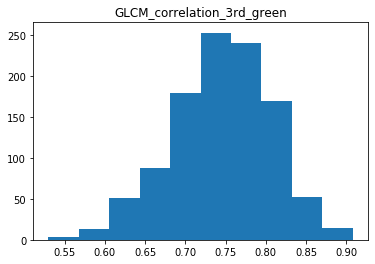

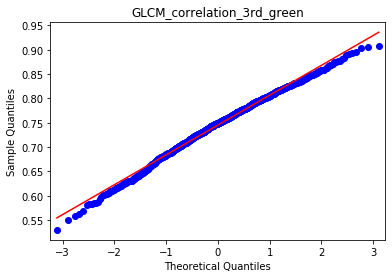

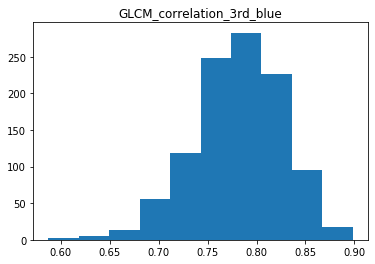

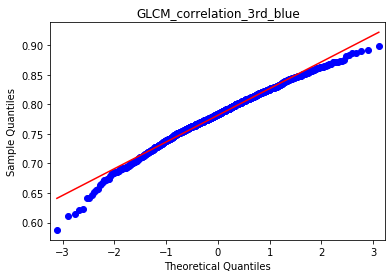

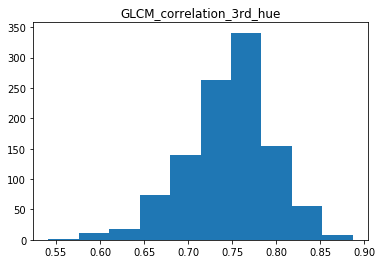

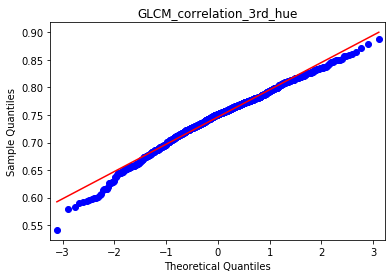

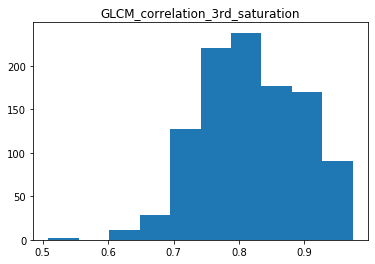

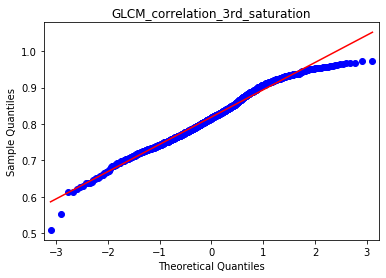

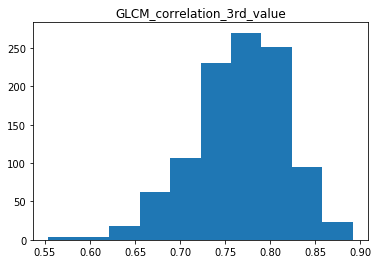

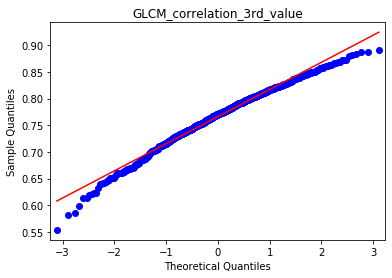

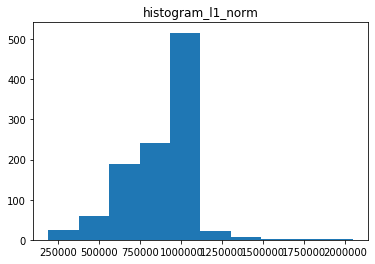

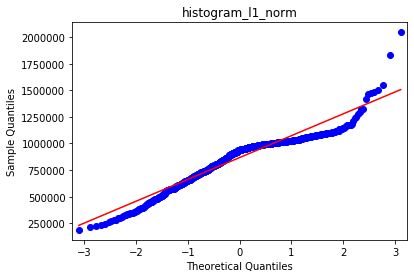

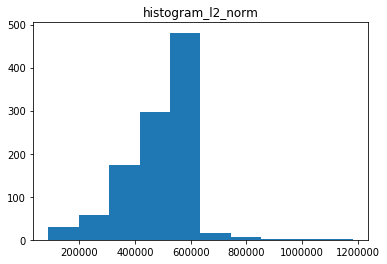

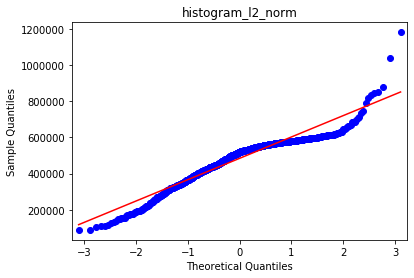

In [7]:
import statsmodels.api as sm 
from statsmodels.graphics.gofplots import qqplot

def normality_inspection(df):
    for name in df.columns:
        #Plot density histogram
        df_aux = df[name]
        #ax = df_aux.plot.kde(ind=n)
        histogram = plt.hist(df_aux)
        plt.title(name)
        #plt.savefig("./Documents/Doctorado/SIIM ISIC Melanoma Classification/Imagenes/Datos pre-transformación/" + name + "_histogram.png")
        
        #Plot QQ-plot
        qq = qqplot(df_aux, line='s')
        plt.title(name)
        #plt.savefig("./Documents/Doctorado/SIIM ISIC Melanoma Classification/Imagenes/Datos pre-transformación/" + name + "_qqplot.png")
        plt.show()

normality_inspection(df_adjusted)

In [19]:
import math
from scipy import stats

def data_transformation(df_adjusted):
    df_transformed = DataFrame()
    
    #Group data by type of distribution
    right_names = ["mean red", "mean lightness", "distance_between_centroids_red",
                   "distance_between_centroids_green", "distance_between_centroids_blue",
                   "distance_between_centroids_hue", "distance_between_centroids_saturation",
                   "distance_between_centroids_value", "distance_between_centroids_lightness",
                   "distance_between_centroids_colorA", "distance_between_centroids_colorB",
                   "GLCM_contrast_1st_red", "GLCM_contrast_1st_green", "GLCM_contrast_1st_blue",
                   "GLCM_contrast_1st_hue", "GLCM_contrast_1st_saturation", "GLCM_contrast_1st_value",
                   "GLCM_contrast_2nd_red", "GLCM_contrast_2nd_green", "GLCM_contrast_2nd_blue",
                   "GLCM_contrast_2nd_hue", "GLCM_contrast_2nd_saturation", "GLCM_contrast_2nd_value",
                   "GLCM_contrast_3rd_red", "GLCM_contrast_3rd_green", "GLCM_contrast_3rd_blue",
                   "GLCM_contrast_3rd_hue", "GLCM_contrast_3rd_saturation", "GLCM_contrast_3rd_value",
                   "GLCM_dissimilarity_1st_red", "GLCM_dissimilarity_1st_green", "GLCM_dissimilarity_1st_blue",
                   "GLCM_dissimilarity_1st_hue", "GLCM_dissimilarity_1st_saturation",
                   "GLCM_dissimilarity_1st_value", "GLCM_dissimilarity_2dn_red",
                   "GLCM_dissimilarity_2dn_green", "GLCM_dissimilarity_2dn_blue",
                   "GLCM_dissimilarity_2dn_hue", "GLCM_dissimilarity_2dn_saturation",
                   "GLCM_dissimilarity_2dn_value", "GLCM_dissimilarity_3rd_red",
                   "GLCM_dissimilarity_3rd_green", "GLCM_dissimilarity_3rd_blue",
                   "GLCM_dissimilarity_3rd_hue", "GLCM_dissimilarity_3rd_saturation",
                   "GLCM_dissimilarity_3rd_value"]
    
    left_names = ["mean saturation", "standard deviation red", "standard deviation green",
                  "standard deviation blue", "standard deviation colorB", "standard deviation lightness",
                  "histogram_l1_norm", "histogram_l2_norm", "GLCM_homogeneity_1st_red",
                  "GLCM_homogeneity_1st_green", "GLCM_homogeneity_1st_blue", "GLCM_homogeneity_1st_hue",
                  "GLCM_homogeneity_1st_saturation", "GLCM_homogeneity_1st_value", "GLCM_homogeneity_2nd_red",
                  "GLCM_homogeneity_2nd_green", "GLCM_homogeneity_2nd_blue", "GLCM_homogeneity_2nd_hue",
                  "GLCM_homogeneity_2nd_saturation", "GLCM_homogeneity_2nd_value", "GLCM_homogeneity_3rd_red",
                  "GLCM_homogeneity_3rd_green", "GLCM_homogeneity_3rd_blue", "GLCM_homogeneity_3rd_hue",
                  "GLCM_homogeneity_3rd_saturation", "GLCM_homogeneity_3rd_value", "GLCM_energy_1st_red",
                  "GLCM_energy_1st_green", "GLCM_energy_1st_blue", "GLCM_energy_1st_hue",
                  "GLCM_energy_1st_saturation", "GLCM_energy_1st_value", "GLCM_energy_2nd_red",
                  "GLCM_energy_2nd_green", "GLCM_energy_2nd_blue", "GLCM_energy_2nd_hue",
                  "GLCM_energy_2nd_saturation", "GLCM_energy_2nd_value", "GLCM_energy_3rd_red",
                  "GLCM_energy_3rd_green", "GLCM_energy_3rd_blue", "GLCM_energy_3rd_hue",
                  "GLCM_energy_3rd_saturation", "GLCM_energy_3rd_value","GLCM_correlation_1st_red",
                  "GLCM_correlation_1st_green", "GLCM_correlation_1st_blue", "GLCM_correlation_1st_hue",
                  "GLCM_correlation_1st_saturation", "GLCM_correlation_1st_value", "GLCM_correlation_2nd_red",
                  "GLCM_correlation_2nd_green", "GLCM_correlation_2nd_blue", "GLCM_correlation_2nd_hue",
                  "GLCM_correlation_2nd_saturation", "GLCM_correlation_2nd_value", "GLCM_correlation_3rd_red",
                  "GLCM_correlation_3rd_green", "GLCM_correlation_3rd_blue", "GLCM_correlation_3rd_hue",
                  "GLCM_correlation_3rd_saturation", "GLCM_correlation_3rd_value"]
    
    light_tailed_names = ["mean value", "kurtosis hue", "kurtosis hue", "kurtosis saturation",
                          "GLCM_ASM_1st_red", "GLCM_ASM_1st_green", "GLCM_ASM_1st_blue",
                          "GLCM_ASM_1st_hue", "GLCM_ASM_1st_saturation", "GLCM_ASM_1st_value",
                          "GLCM_ASM_2nd_red", "GLCM_ASM_2nd_green", "GLCM_ASM_2nd_blue",
                          "GLCM_ASM_2nd_hue", "GLCM_ASM_2nd_saturation", "GLCM_ASM_2nd_value",
                          "GLCM_ASM_3rd_red", "GLCM_ASM_3rd_green", "GLCM_ASM_3rd_blue",
                          "GLCM_ASM_3rd_hue", "GLCM_ASM_3rd_saturation", "GLCM_ASM_3rd_value"]
    
    heavy_tailed_names = ["mean green", "mean blue", "mean hue", "mean colorA", "mean colorB",
                          "standard deviation hue", "standard deviation saturation",
                          "standard deviation value", "standard deviation colorA", "kurtosis red",
                          "kurtosis green", "kurtosis colorA"]
    
    outlier = ["skewness red", "skewness green", "skewness blue", "skewness hue",
               "skewness saturation", "skewness value", "skewness lightness",
               "skewness colorA", "skewness colorB", "kurtosis blue", "kurtosis value",
               "kurtosis lightness", "skewness colorB"]
    
    #Transform right skewness data
    for name in right_names:
        df_transformed[name] = (df_adjusted[name] + abs(df_adjusted[name].min()) + 1).apply(lambda x: math.log10(x))
        
    #Transform left skewness data
    for name in left_names:
        df_transformed[name] = df_adjusted[name].max() - df_adjusted[name]
        df_transformed[name] = (df_transformed[name] + abs(df_transformed[name].min()) + 1).apply(lambda x: math.log10(x))
    
    #Transform light tailed data
    for name in light_tailed_names:
        df_transformed[name] = np.median(df_adjusted[name]) - df_adjusted[name]
        df_transformed[name] = df_transformed[name].max() - df_transformed[name]
        df_transformed[name] = (df_transformed[name] + abs(df_transformed[name].min()) + 1).apply(lambda x: math.log10(x))
    
    #Transform heavy tailed data
    for name in heavy_tailed_names:
        df_transformed[name] = np.median(df_adjusted[name]) - df_adjusted[name]
        df_transformed[name] = (df_transformed[name] + abs(df_transformed[name].min()) + 1).apply(lambda x: math.log10(x))
    return df_transformed

#df_transformation = data_transformation(df_adjusted)
df_fitted = DataFrame()
for col in df_adjusted.columns:
    df_fitted[col], fitted_lambda = stats.boxcox(df_adjusted[col]) 
#normality_inspection(df_transformation)
#df_transformation.to_excel("./Documents/Doctorado/SIIM ISIC Melanoma Classification/Features transdormed.xlsx")

C:\Users\marth\Anaconda3\lib\site-packages\scipy\stats\morestats.py:906: RuntimeWarning: overflow encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
C:\Users\marth\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\marth\Anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\marth\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [20]:
#Define percentage for training-testing split
percentage = 30
partition = int(len(df)*percentage/100)

#Split training and testing set
x_train, x_test = df_fitted[partition:],  df_fitted[:partition]
y_train, y_test = df_label[partition:], df_label[:partition]

print("size of training set: " + str(x_train.shape))
print("size of testing set: " + str(x_test.shape))
print("length of training label vector: " + str(len(y_train)))
print("length of testing label vector: " + str(len(y_test)))

size of training set: (700, 164)
size of testing set: (300, 164)
length of training label vector: 700
length of testing label vector: 300


In [4]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#Define parameters and variables
n_neighbors = 15
models = []
fprs = []
tprs = []
aucs = []

#Train models
models.append(svm.SVC())
models.append(KNeighborsClassifier(n_neighbors))
models.append(GaussianNB())
models.append(LinearDiscriminantAnalysis())
models.append(DecisionTreeClassifier(random_state=0))

for model in models:
    model.fit(x_train, y_train) #Fit models
    y_pred = model.predict(x_test) #Predict models
    print("The accuracy was: " + str(metrics.accuracy_score(y_test, y_pred)))
    print("The confusion matrix was: " + str(metrics.confusion_matrix(y_test, y_pred)))
    print("The classification report is: " + str(metrics.classification_report(y_test, y_pred)))
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(auc)


In [18]:
#Implement cross-validation

#Optimal parameter to test for SVM
#c_param = [ 1, 2, 3, 4, 5]
c_param = [2]
#g_param = [0.1, 0.5, 1, 5, 10]
g_param = [0.1]
k_param = ['linear']


#Cross validation with optional parameters
cv_scores = []
final_c = []
final_k = []
final_g = []
n=0
for c in c_param:
    for gammas in g_param:
        for kernels in k_param:
            clf = svm.SVC(C=c,kernel=kernels, gamma=gammas, probability=True)
            scores = cross_val_score(clf, x_train, y_train, cv=10, scoring='accuracy')
            cv_scores.append(scores.mean())
            final_c.append(c)
            final_k.append(kernels)
            final_g.append(gammas)
            print("ciclo terminado: " + str(n))
            n+=1

#Find optimals
MSE = [1-x for x in cv_scores]
optimal_index = MSE.index(min(MSE))
optimal_c = final_c[optimal_index]
optimal_kernel = final_k[optimal_index]
optimal_gamma = final_g[optimal_index]

#Print results
print("Optimal C: " + str(optimal_c))
print("Optimal kerne: " + str(optimal_kernel))
print("Optimal gamma: " + str(optimal_gamma))
print("Accuracy: " + str(max(cv_scores)))

C:\Users\marth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\marth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\marth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\marth\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

ciclo terminado: 0
Optimal C: 2
Optimal kerne: linear
Optimal gamma: 0.1
Accuracy: 0.7528571428571429


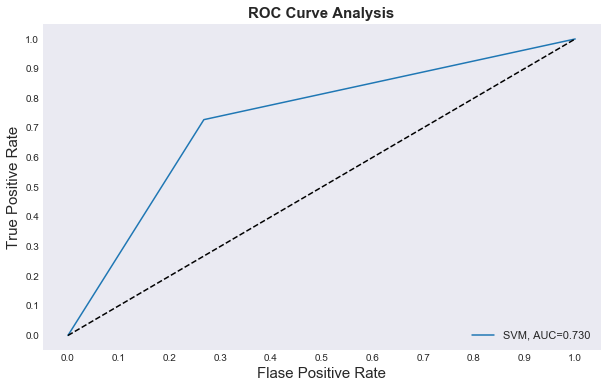

In [30]:
import matplotlib.pyplot as plt

#Name of classifiers for labels
names = []
names.append("SVM")
names.append("KNN")
names.append("Naive Bayes")
names.append("LDA")
names.append("Decision Tree")

#Plot AUC-ROC
fig = plt.figure(figsize=(10,6))
plt.style.use('seaborn-dark')

#for i in range(5):
for i in range(1):
    plt.plot(fprs[i], 
             tprs[i], 
             label="{}, AUC={:.3f}".format(names[i], aucs[i]))
    
plt.plot([0,1], [0,1], color='black', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':11}, loc='lower right')

plt.show()
#fig.savefig('./Documents/Doctorado/Información General Seminarios/Presentación de avances/AUC-ROC Curves.png')

In [114]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']
